In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder

# Scaling and Splitting
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


#Unbalance problems
from imblearn.over_sampling import SMOTE

# Evaluation
from sklearn.metrics import f1_score,accuracy_score, precision_score,recall_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, roc_curve,roc_auc_score



import warnings 
warnings.filterwarnings(action='ignore')
sns.set()

In [2]:
df = pd.read_csv("possibleDataset/weatherAUS.csv")
df.isnull().sum(), df.shape

(Date                 0
 Location             0
 MinTemp           1485
 MaxTemp           1261
 Rainfall          3261
 Evaporation      62790
 Sunshine         69835
 WindGustDir      10326
 WindGustSpeed    10263
 WindDir9am       10566
 WindDir3pm        4228
 WindSpeed9am      1767
 WindSpeed3pm      3062
 Humidity9am       2654
 Humidity3pm       4507
 Pressure9am      15065
 Pressure3pm      15028
 Cloud9am         55888
 Cloud3pm         59358
 Temp9am           1767
 Temp3pm           3609
 RainToday         3261
 RainTomorrow      3267
 dtype: int64,
 (145460, 23))

## Data Preprocessing

In [3]:
df = df[df['RainTomorrow'].notna() & df['RainToday'].notna() & df['Sunshine'].notna()]

### Categorical Data

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df0 = df.copy()
df = df.drop('RainTomorrow',axis=1)
df['Month'] = df['Date'].dt.month
df['RainTomorrow'] = df0['RainTomorrow'] 

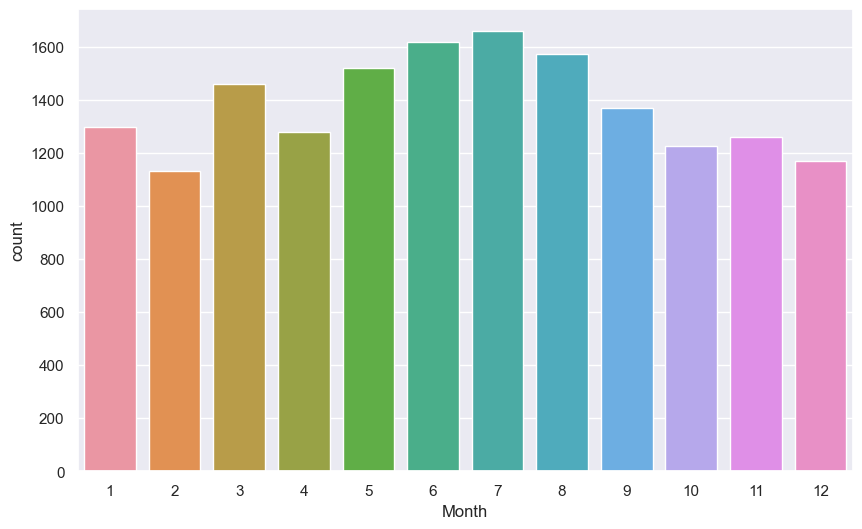

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(data=df[df['RainTomorrow']=='Yes'],x='Month');

There are monts where the chances of raining increases, specially during summer

Location and Wind Directions are features that normaly have something to do with rains

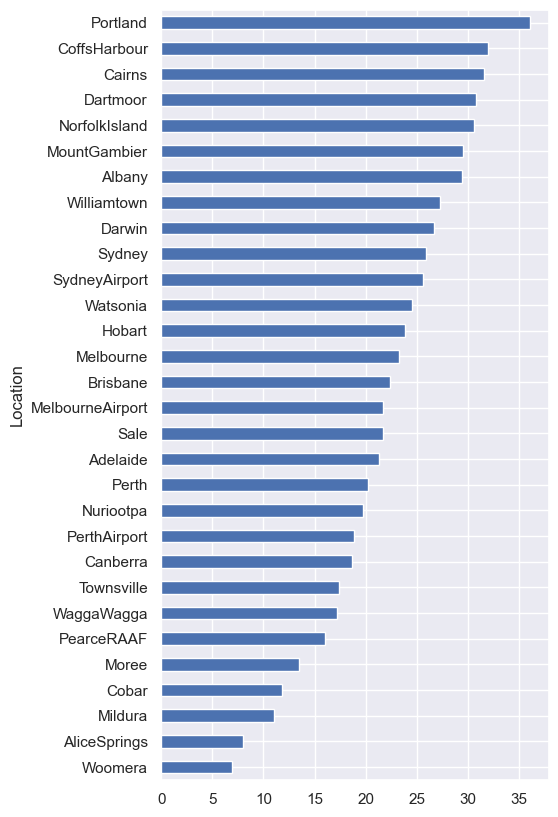

In [6]:
rainLoc_df=pd.crosstab(df['Location'],df['RainTomorrow']) 
# getting percentage of raining days and non raining days for each city 
rainLoc_df=rainLoc_df/rainLoc_df.transpose().sum().values.reshape((-1, 1))*100
rainLoc_sorted = rainLoc_df.sort_values(by='Yes',ascending=True )
rainLoc_sorted.Yes.plot(kind="barh",figsize=(5,10));

In [7]:
windgust_df=pd.crosstab(df['WindGustDir'],df['RainTomorrow']) 
windgust_df=windgust_df/windgust_df.transpose().sum().values.reshape((-1, 1))*100
windgust_df = windgust_df.sort_values(by='Yes',ascending=True )

In [8]:
winddir9am_df=pd.crosstab(df['WindDir9am'],df['RainTomorrow']) 
winddir9am_df=winddir9am_df/winddir9am_df.transpose().sum().values.reshape((-1, 1))*100
winddir9am_df = winddir9am_df.sort_values(by='Yes',ascending=True )

In [9]:
winddir3pm_df=pd.crosstab(df['WindDir3pm'],df['RainTomorrow']) 
winddir3pm_df=winddir3pm_df/winddir3pm_df.transpose().sum().values.reshape((-1, 1))*100
winddir3pm_df = winddir3pm_df.sort_values(by='Yes',ascending=True )

<AxesSubplot:>

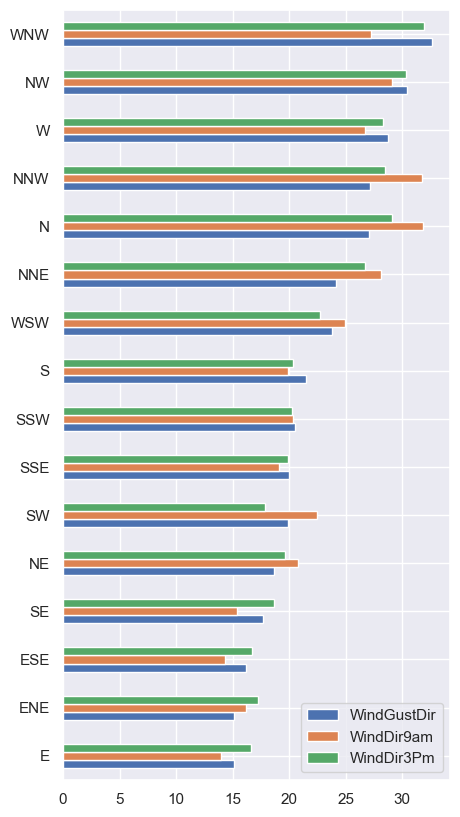

In [10]:
windDirs = pd.concat([windgust_df.Yes, winddir9am_df.Yes, winddir3pm_df.Yes], axis=1)
windDirs.columns = ['WindGustDir','WindDir9am','WindDir3Pm']
windDirs.plot(kind="barh",figsize=(5,10))

In [11]:
location_label_maping={}
for n, location in enumerate(rainLoc_sorted.index):
    location_label_maping[location] = n
df['Location'] = df['Location'].map(location_label_maping) 


windir_label_maping={}
for n, windir in enumerate(windDirs.index):
    windir_label_maping[windir] = n
df['WindGustDir'] = df['WindGustDir'].map(windir_label_maping)  
df['WindDir9am'] = df['WindDir9am'].map(windir_label_maping)  
df['WindDir3pm'] = df['WindDir3pm'].map(windir_label_maping)  

df['RainToday'] = df['RainToday'].map({'No':0, 'Yes':1})  

In [12]:
categorical = ['WindGustDir','WindDir9am','WindDir3pm','Location','RainToday']
df_labeled =  df.drop(['Date'],axis=1)
df_labeled.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Month', 'RainTomorrow'],
      dtype='object')

### Handling Outliers 

In [13]:
def box_plot(dataf_outliers, df_no_outliers):
    plt.figure(figsize=(10,4))
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    sns.boxplot(data=dataf_outliers.values, palette='pastel', ax = axes[0])
    axes[0].set_title(f'Box Plot: {dataf_outliers.name} - With Outliers')
    sns.boxplot(data=df_no_outliers.values, palette='pastel', ax = axes[1])
    axes[1].set_title(f'Box Plot: {df_no_outliers.name} - Without Outliers')  
    plt.show()


def drop_outliers(dataf, colname):
    dfcol = dataf[colname]
    dfcol = dfcol[~np.isnan(dfcol)]
    iqr = 1.5*(np.percentile(dfcol,75)-np.percentile(dfcol,25))
    
    dataf.drop(dataf[dataf[colname] > (iqr + np.percentile(dfcol,75))].index, inplace=True)
    dataf.drop(dataf[dataf[colname] < (np.percentile(dfcol,25)-iqr)].index, inplace=True)
    return dataf[colname]

outliers: (73905,), no outliers: (73967,)


<Figure size 1000x400 with 0 Axes>

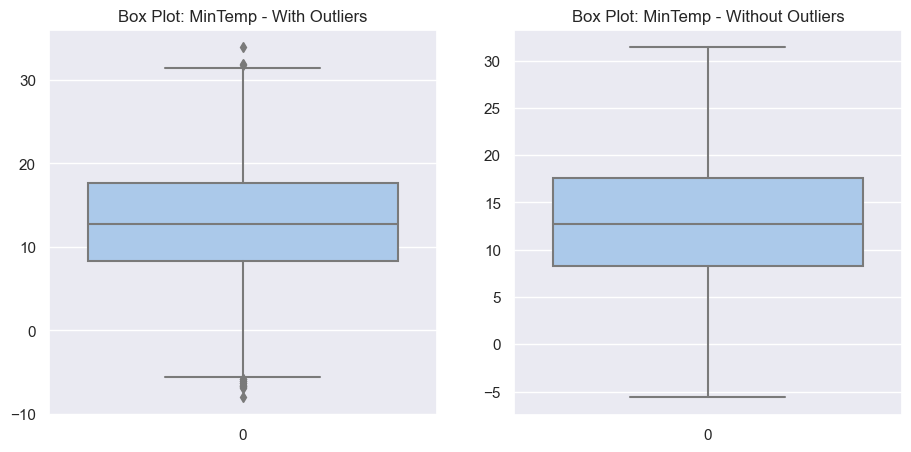

outliers: (73923,), no outliers: (73945,)


<Figure size 1000x400 with 0 Axes>

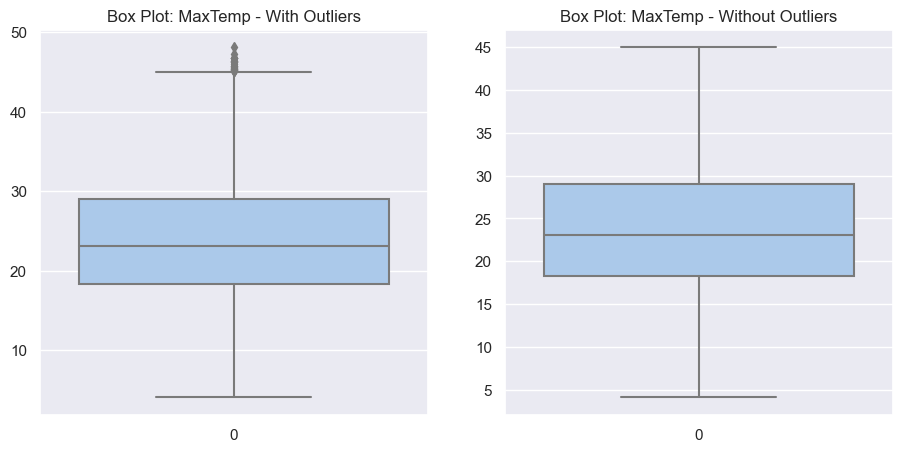

outliers: (73945,), no outliers: (60602,)


<Figure size 1000x400 with 0 Axes>

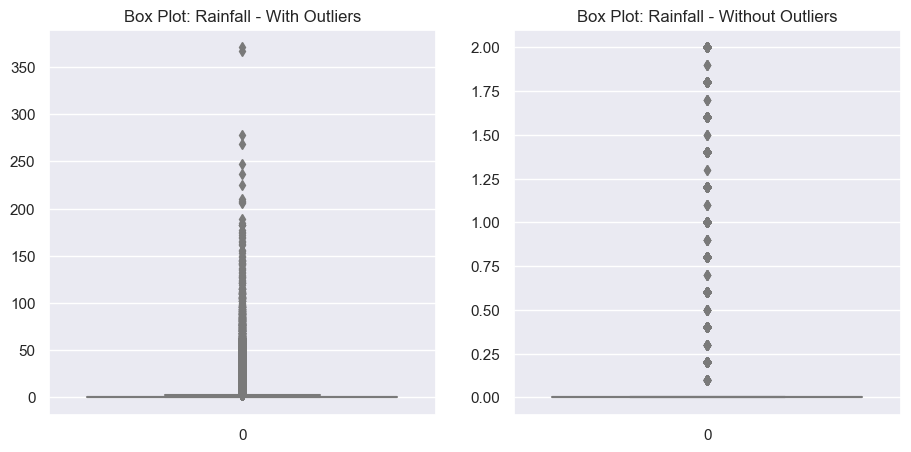

outliers: (57642,), no outliers: (59349,)


<Figure size 1000x400 with 0 Axes>

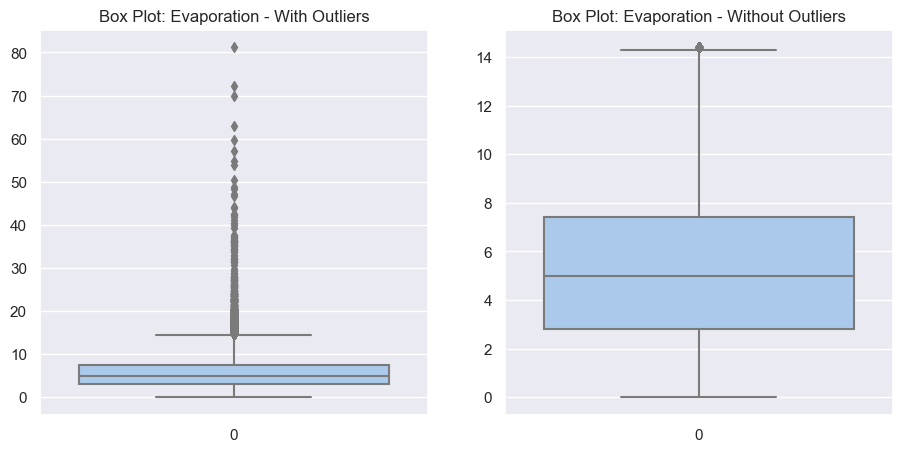

outliers: (59349,), no outliers: (59349,)


<Figure size 1000x400 with 0 Axes>

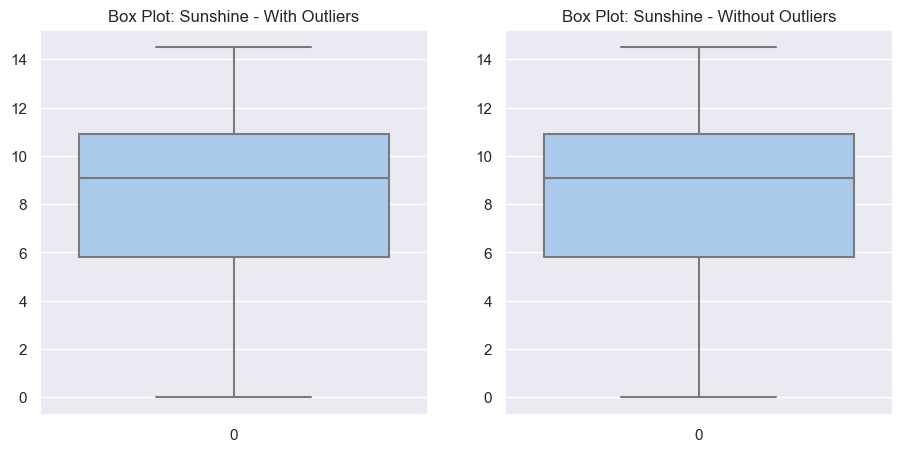

outliers: (56008,), no outliers: (57448,)


<Figure size 1000x400 with 0 Axes>

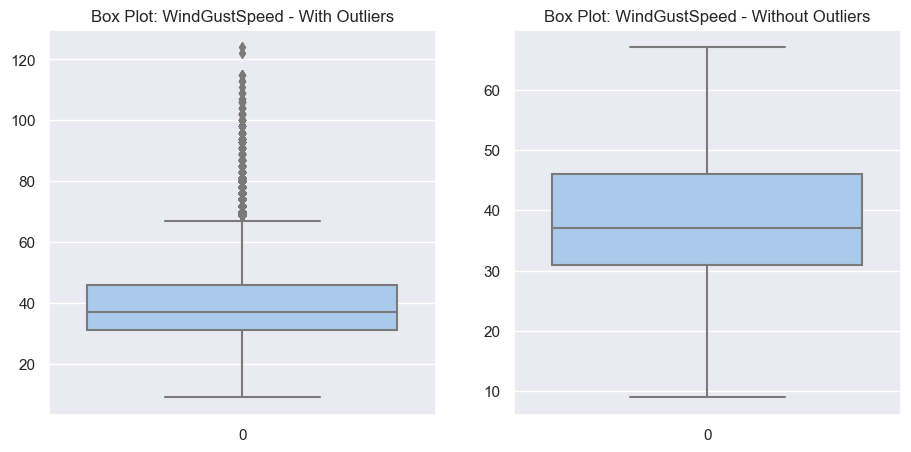

outliers: (57334,), no outliers: (56737,)


<Figure size 1000x400 with 0 Axes>

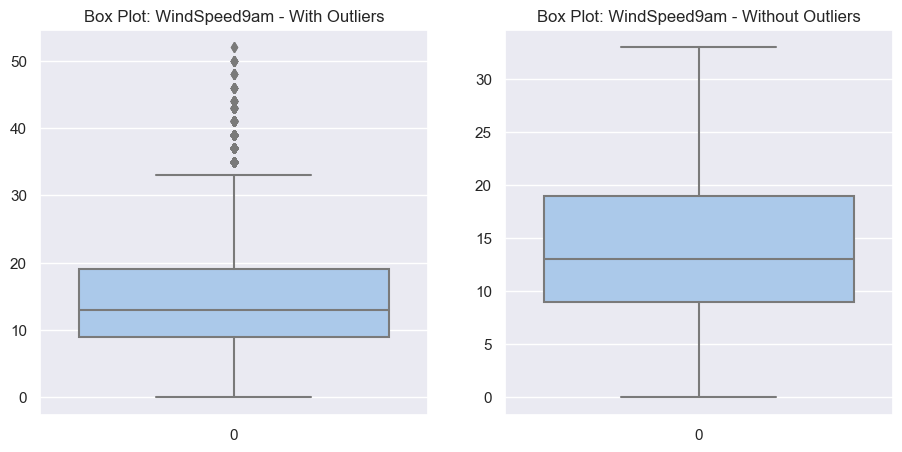

outliers: (56449,), no outliers: (56453,)


<Figure size 1000x400 with 0 Axes>

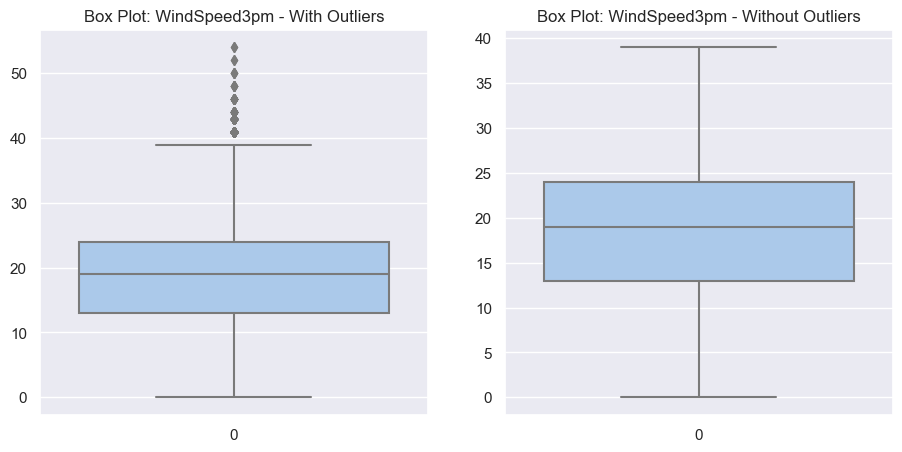

outliers: (56175,), no outliers: (55651,)


<Figure size 1000x400 with 0 Axes>

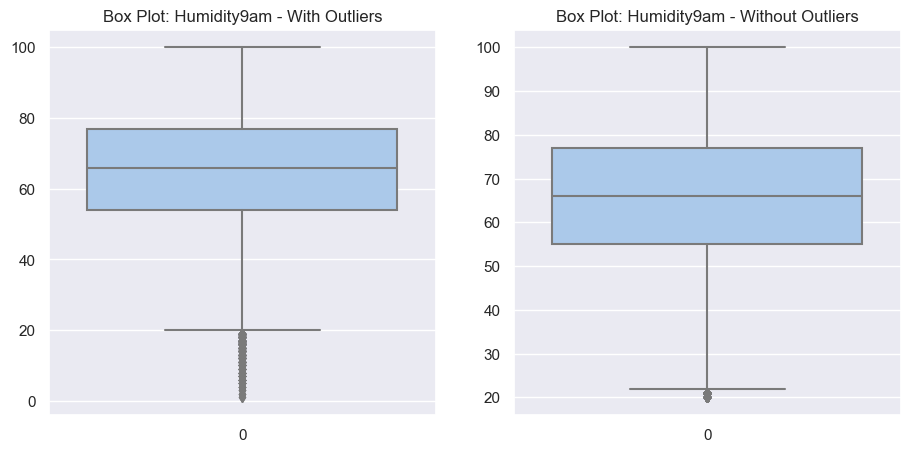

outliers: (55230,), no outliers: (55651,)


<Figure size 1000x400 with 0 Axes>

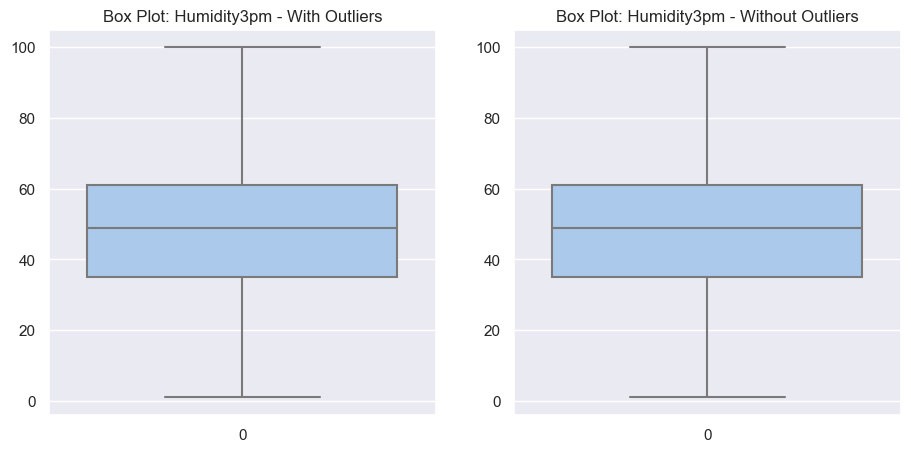

outliers: (55564,), no outliers: (55257,)


<Figure size 1000x400 with 0 Axes>

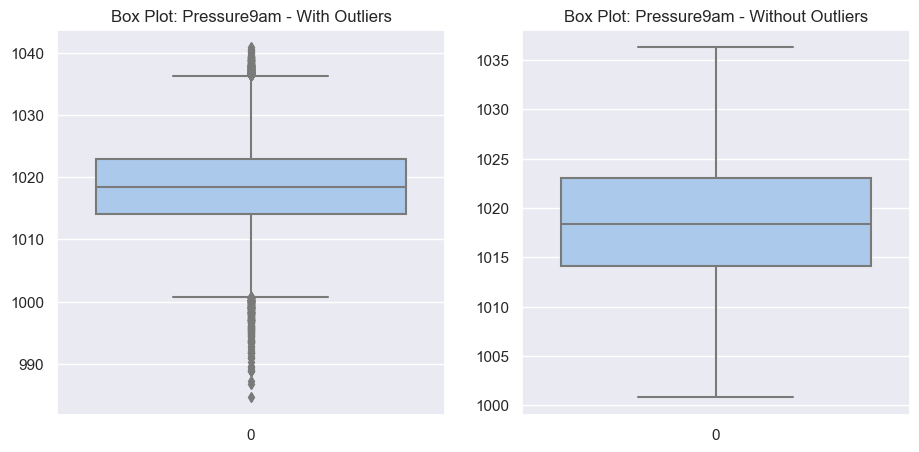

outliers: (55168,), no outliers: (55137,)


<Figure size 1000x400 with 0 Axes>

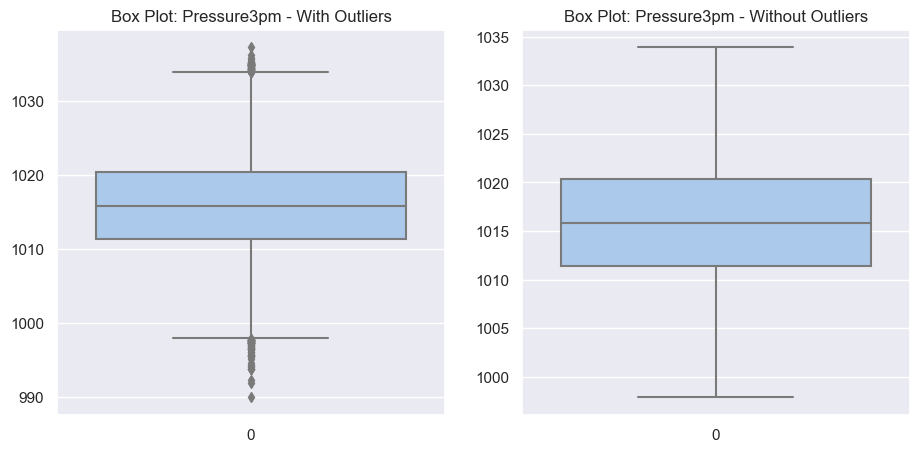

outliers: (49393,), no outliers: (55137,)


<Figure size 1000x400 with 0 Axes>

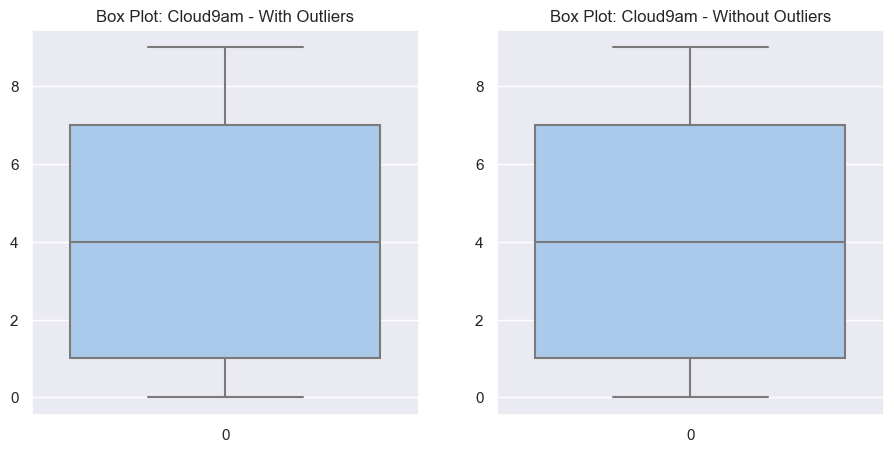

outliers: (48148,), no outliers: (55137,)


<Figure size 1000x400 with 0 Axes>

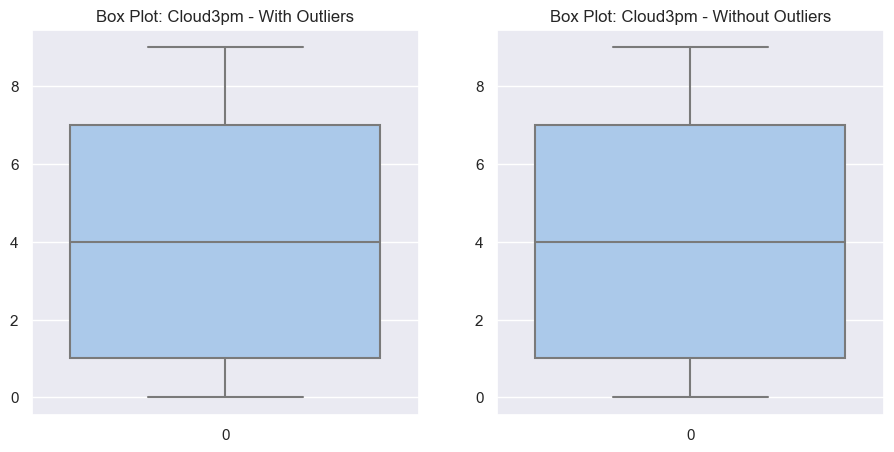

outliers: (55061,), no outliers: (55135,)


<Figure size 1000x400 with 0 Axes>

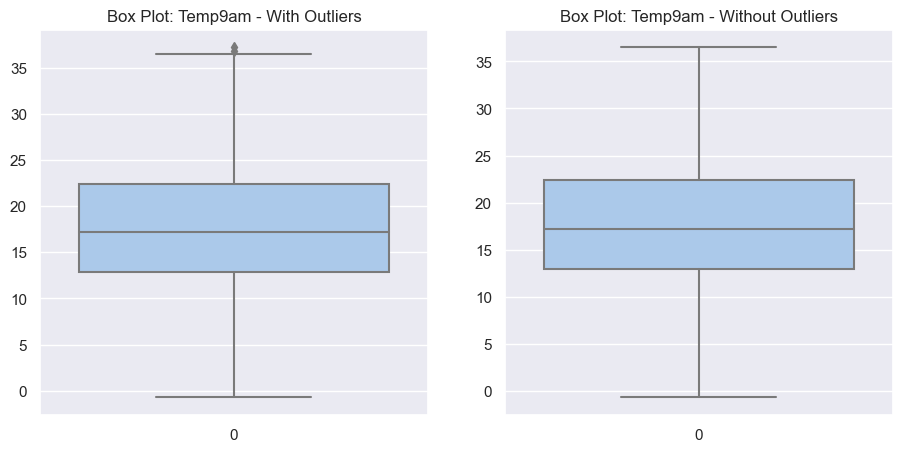

outliers: (54892,), no outliers: (55104,)


<Figure size 1000x400 with 0 Axes>

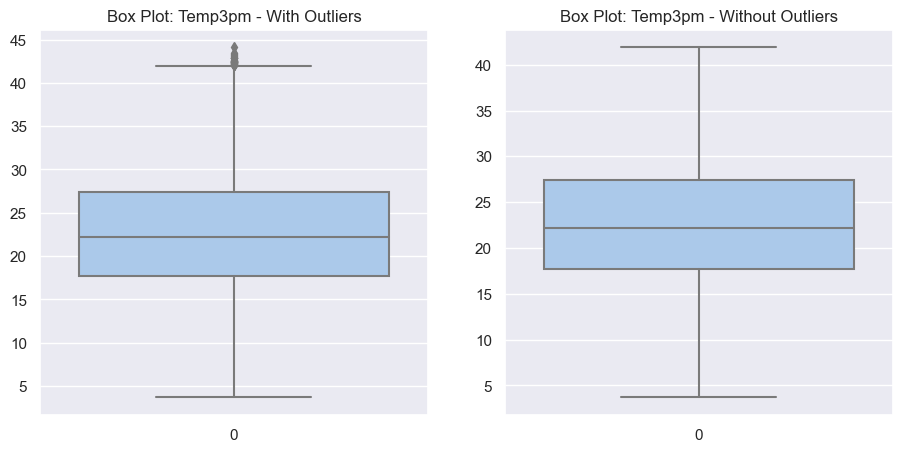

outliers: (55104,), no outliers: (55104,)


<Figure size 1000x400 with 0 Axes>

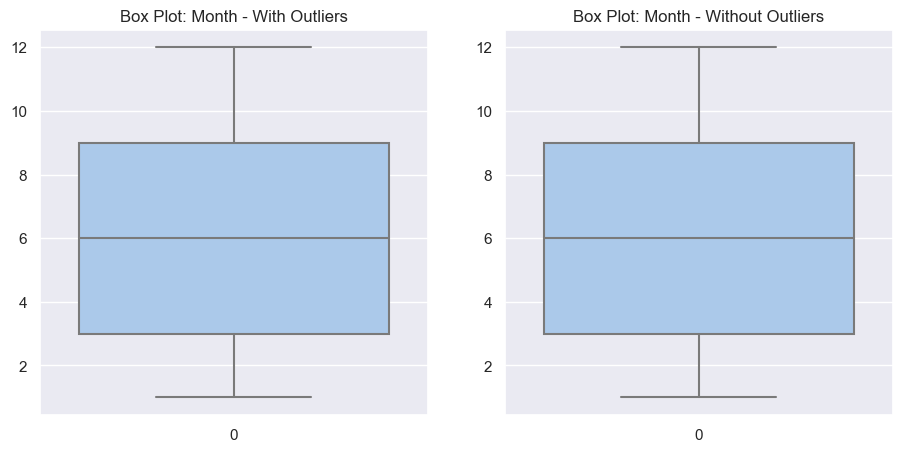

In [14]:
for col in df_labeled.columns:
    if col not in categorical + ['RainTomorrow']:
        dfcol = df_labeled[col]
        dfcol = dfcol[~np.isnan(dfcol)]
        df_no_outliers = drop_outliers(df_labeled, col)
        print(f'outliers: {dfcol.shape}, no outliers: {df_no_outliers.shape}')
        box_plot(dfcol, df_no_outliers)

### Handling Missing Values

In [15]:
def fill_mean(datacol):
    dataunique = datacol.unique()
    dataunique = dataunique[~np.isnan(dataunique)]
    data_mean = np.mean(dataunique)
    return datacol.fillna(data_mean)

In [16]:
for col in df_labeled.columns:
    if col not in ['RainTomorrow']:
        df_labeled[col] = fill_mean(df_labeled[col])

In [17]:
df_labeled.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Month            0
RainTomorrow     0
dtype: int64

In [18]:
df_labeled['RainTomorrow'] = df_labeled['RainTomorrow'].map({'No':0, 'Yes':1})  
X = df_labeled.drop('RainTomorrow',axis=1)
y = df_labeled['RainTomorrow']
X.shape

(55104, 22)

In [19]:
df_labeled0 = df_labeled.groupby('RainTomorrow', group_keys=False).apply(lambda x: x.sample(frac=0.1))
X = df_labeled0.drop('RainTomorrow',axis=1)
y = df_labeled0['RainTomorrow']
df_labeled0.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
117651         9     20.0     28.9       0.0          9.0      10.7   
37496          6      5.9     19.9       0.0          4.0       9.1   
123484        11      4.0     18.2       0.0          2.0       7.6   
100802        24      9.0     14.7       0.0          0.6       2.1   
108146         0     17.4     31.3       0.0         11.8       4.1   

        WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity3pm  \
117651          5.0           39.0         8.0         5.0  ...         50.0   
37496           4.0           39.0         2.0         1.0  ...         35.0   
123484         11.0           44.0        10.0        10.0  ...         46.0   
100802         11.0           33.0        11.0        11.0  ...         66.0   
108146         12.0           57.0        11.0        12.0  ...         14.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
117651       1013.9       1011.7       7.0       1.0     21.8     27.8   
37496        1021.3       1020.2       1.0       5.0     15.0     17.9   
123484       1020.7       1016.0       1.0       2.0     10.8     17.4   
100802       1008.6       1006.2       7.0       7.0     10.7     13.5   
108146       1016.6       1013.4       7.0       7.0     22.3     29.5   

        RainToday  Month  RainTomorrow  
117651          0      1             0  
37496           0      9             0  
123484          0      7             0  
100802          0      7             0  
108146          0      4             0  

[5 rows x 23 columns]

In [20]:
mayority_weight = y.value_counts()[0]/y.shape[0]
minority_weight = y.value_counts()[1]/y.shape[0]
print(mayority_weight, minority_weight)

0.8446460980036298 0.15535390199637023


### Unbalance problems

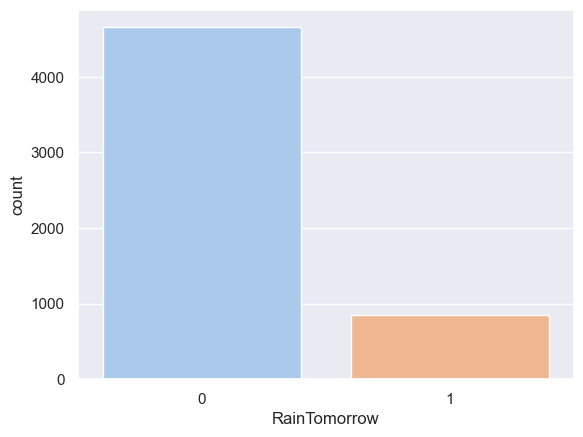

In [21]:
ax = sns.countplot(x=y, palette='pastel')

## Functions

In [22]:
def store_metrics(metr, ytest, ypr):
    metr[0].append(roc_auc_score(ytest, ypr))
    metr[1].append(f1_score(ytest, ypr))
    metr[2].append(precision_score(ytest, ypr))
    metr[3].append(recall_score(ytest, ypr))
    return metr

In [23]:
def calculate_KNN(Xtrain_resampled,Xtrain,ytrain_resampled,ytrain,Xtest,ytest, neighbors = 30):
    aucscores_resampled = []
    aucscores = []
    
    for k in range(1,neighbors):
        knn = KNeighborsClassifier(n_neighbors = k, weights='distance')
        knn.fit(Xtrain_resampled, ytrain_resampled)
        ypred_resampled = knn.predict(Xtest) 
        ## computing f1 score
        score = roc_auc_score(ytest, ypred_resampled)
        aucscores_resampled.append(score)
        
        knn = KNeighborsClassifier(n_neighbors = k,weights='distance')
        knn.fit(Xtrain, ytrain)
        ypred = knn.predict(Xtest) 
        ## computing f1 score
        score = roc_auc_score(ytest, ypred)
        aucscores.append(score)


    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    sns.set(font_scale = 1)
    sns.lineplot(y=aucscores_resampled, x=range(1,neighbors), ax = axes[0])
    axes[0].set_title('Balanced Dataset')
    axes[0].set(xlabel='Neighbors', ylabel='ROC-AUC Score')
    sns.lineplot(y=aucscores, x=range(1,neighbors), ax = axes[1])
    axes[1].set_title('Unbalanced Dataset')
    axes[1].set(xlabel='Neighbors', ylabel='ROC-AUC Score')
    
    return np.where(aucscores==np.max(aucscores))[0][0]+1,np.where(aucscores_resampled==np.max(aucscores_resampled))[0][0] +1


# FEATURE SUBSET SELECTION: MULTIVARIATE FILTER

In [24]:
df_labeled0.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Month', 'RainTomorrow'],
      dtype='object')

In [25]:
df_labeled0

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
117651         9     20.0     28.9       0.0          9.0      10.7   
37496          6      5.9     19.9       0.0          4.0       9.1   
123484        11      4.0     18.2       0.0          2.0       7.6   
100802        24      9.0     14.7       0.0          0.6       2.1   
108146         0     17.4     31.3       0.0         11.8       4.1   
...          ...      ...      ...       ...          ...       ...   
61952         13     15.3     29.8       0.0          5.4       3.5   
94320          7     23.3     30.2       0.0         10.0       6.6   
9877          28     15.5     26.5       0.2          4.0       8.7   
33799         19     10.0     19.6       2.0          3.6       8.8   
62182         13     10.1     30.4       0.2          3.8       6.9   

        WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity3pm  \
117651          5.0           39.0         8.0         5.0  ...         50.0   
37496           4.0           39.0         2.0         1.0  ...         35.0   
123484         11.0           44.0        10.0        10.0  ...         46.0   
100802         11.0           33.0        11.0        11.0  ...         66.0   
108146         12.0           57.0        11.0        12.0  ...         14.0   
...             ...            ...         ...         ...  ...          ...   
61952           0.0           30.0        12.0         0.0  ...         46.0   
94320           0.0           39.0         2.0         1.0  ...         52.0   
9877            5.0           43.0         7.5         6.0  ...         68.0   
33799           5.0           63.0         9.0         5.0  ...         45.0   
62182          14.0           46.0         0.0        14.0  ...         33.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
117651       1013.9       1011.7       7.0       1.0     21.8     27.8   
37496        1021.3       1020.2       1.0       5.0     15.0     17.9   
123484       1020.7       1016.0       1.0       2.0     10.8     17.4   
100802       1008.6       1006.2       7.0       7.0     10.7     13.5   
108146       1016.6       1013.4       7.0       7.0     22.3     29.5   
...             ...          ...       ...       ...      ...      ...   
61952        1018.5       1013.8       5.0       6.0     19.1     28.7   
94320        1014.2       1011.5       7.0       5.0     27.9     28.9   
9877         1019.6       1019.0       1.0       3.0     20.9     26.1   
33799        1014.5       1011.6       1.0       6.0     13.5     16.4   
62182        1011.3       1005.8       8.0       6.0     16.0     29.6   

        RainToday  Month  RainTomorrow  
117651          0      1             0  
37496           0      9             0  
123484          0      7             0  
100802          0      7             0  
108146          0      4             0  
...           ...    ...           ...  
61952           0      2             1  
94320           0     11             1  
9877            0      3             1  
33799           1     10             1  
62182           0     10             1  

[5510 rows x 23 columns]

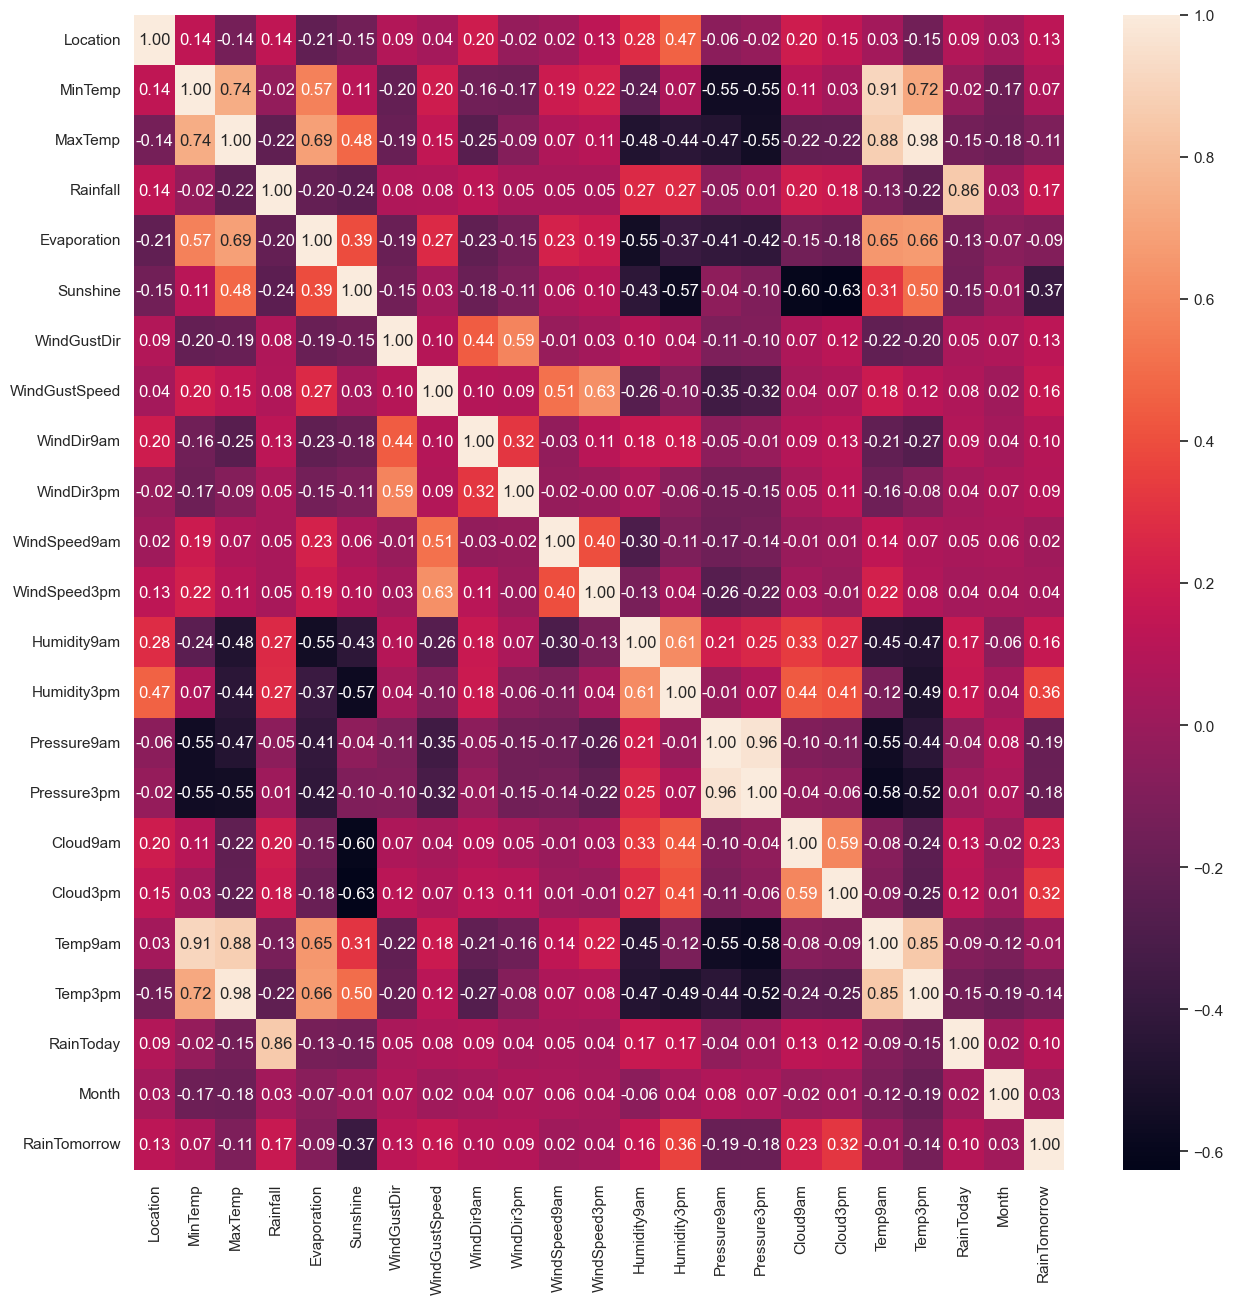

In [26]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(df_labeled0.corr(), annot=True, fmt='.2f') 
plt.show()



# KNN

### SMOTE Oversampling

In [107]:

smote = SMOTE()
stscaler = StandardScaler()
normal = MinMaxScaler()
#normalization
Xnorm = normal.fit_transform(X)
Xnorm = pd.DataFrame(Xnorm, columns=X.columns)
Xnorm.head()

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0  0.310345  0.741071  0.617486       0.0     0.625000  0.758865     0.333333   
1  0.206897  0.321429  0.371585       0.0     0.277778  0.645390     0.266667   
2  0.379310  0.264881  0.325137       0.0     0.138889  0.539007     0.733333   
3  0.827586  0.413690  0.229508       0.0     0.041667  0.148936     0.733333   
4  0.000000  0.663690  0.683060       0.0     0.819444  0.290780     0.800000   

   WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity9am  Humidity3pm  \
0       0.500000    0.533333    0.333333  ...       0.6375     0.479167   
1       0.500000    0.133333    0.066667  ...       0.2875     0.322917   
2       0.589286    0.666667    0.666667  ...       0.4500     0.437500   
3       0.392857    0.733333    0.733333  ...       0.7875     0.645833   
4       0.821429    0.733333    0.800000  ...       0.0375     0.104167   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
0     0.369318     0.384401     0.875     0.125  0.623188  0.612188   
1     0.579545     0.621170     0.125     0.625  0.426087  0.337950   
2     0.562500     0.504178     0.125     0.250  0.304348  0.324100   
3     0.218750     0.231198     0.875     0.875  0.301449  0.216066   
4     0.446023     0.431755     0.875     0.875  0.637681  0.659280   

   RainToday     Month  
0        0.0  0.000000  
1        0.0  0.727273  
2        0.0  0.545455  
3        0.0  0.545455  
4        0.0  0.272727  

[5 rows x 22 columns]

In [109]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
k = Xnorm.shape[1]

kbest = SelectKBest(mutual_info_classif, k=k).fit(Xnorm, y)

In [110]:
univar_features = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(kbest.scores_)], axis=1)
univar_features.columns = ['Features','Scores']
univar_features = univar_features.sort_values(['Scores'], ascending=False).iloc[:,:]
univar_features

Features    Scores
13    Humidity3pm  0.070214
5        Sunshine  0.066772
17       Cloud3pm  0.054035
16       Cloud9am  0.024529
15    Pressure3pm  0.021957
3        Rainfall  0.019244
9      WindDir3pm  0.016590
7   WindGustSpeed  0.015651
14    Pressure9am  0.012732
2         MaxTemp  0.011769
0        Location  0.010346
12    Humidity9am  0.010218
6     WindGustDir  0.008979
8      WindDir9am  0.008179
19        Temp3pm  0.006702
1         MinTemp  0.004730
21          Month  0.004709
18        Temp9am  0.002658
10   WindSpeed9am  0.000000
4     Evaporation  0.000000
20      RainToday  0.000000
11   WindSpeed3pm  0.000000

In [111]:
selected_features = univar_features[univar_features['Scores']>0.01]
drop_features = univar_features[univar_features['Scores']<0.01]
selected_features

Features    Scores
13    Humidity3pm  0.070214
5        Sunshine  0.066772
17       Cloud3pm  0.054035
16       Cloud9am  0.024529
15    Pressure3pm  0.021957
3        Rainfall  0.019244
9      WindDir3pm  0.016590
7   WindGustSpeed  0.015651
14    Pressure9am  0.012732
2         MaxTemp  0.011769
0        Location  0.010346
12    Humidity9am  0.010218

In [112]:
X_new = X.drop(drop_features.Features, axis=1)
Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

#split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)
Xtrain.head()

Location   MaxTemp  Rainfall  Sunshine  WindGustSpeed  WindDir3pm  \
1039 -1.147125  0.095781 -0.398805 -1.868310       1.216216    1.330010   
2443 -0.906860  0.795063 -0.398805  0.667531       0.621242   -1.519826   
2434 -0.426329  0.779861 -0.398805  0.498475       0.323756    1.549228   
127  -1.627656  1.372731  2.121746  1.202875      -0.469542   -0.423736   
3420  1.255528 -1.013950 -0.398805 -1.163910       1.216216   -1.081390   

      Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  
1039    -1.612541    -0.688617    -1.364295    -1.308552  0.775006  1.603648  
2443    -0.430044    -0.094639     0.146992     0.029146 -1.120454 -0.828976  
2434    -1.789915    -1.120601    -0.073404    -0.222656 -0.362270 -0.423538  
127     -1.612541    -1.498587    -1.238354    -1.465928  0.775006 -1.234413  
3420    -1.080417     0.121353     1.138773     1.130779  1.154098  1.198211

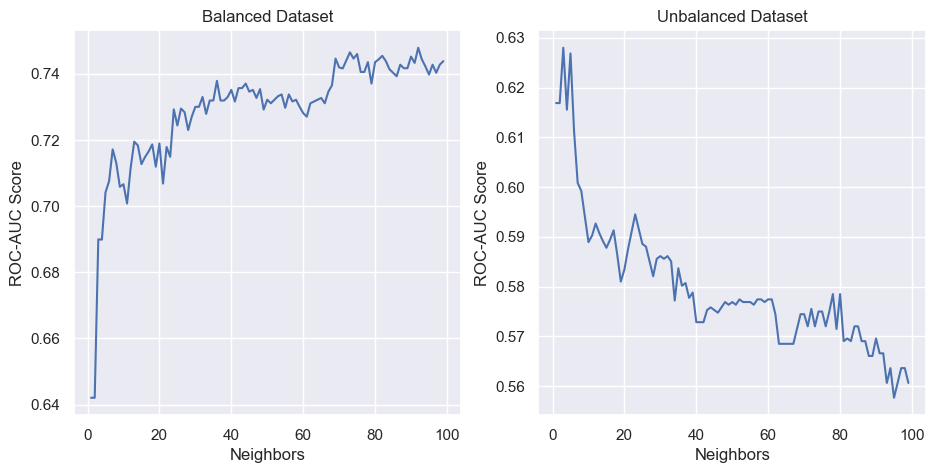

In [113]:
kmax, k_resampled_max = calculate_KNN(Xtrain_resampled,Xtrain,ytrain_resampled,ytrain,Xtest,ytest, neighbors = 100)

In [114]:
print(kmax, k_resampled_max)

3 92


In [115]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    knn_unbalanced = KNeighborsClassifier(n_neighbors = kmax, weights='distance')
    knn_unbalanced.fit(train_X, train_y)
    ypred = knn_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = smote.fit_resample(train_X, train_y)
    knn_balanced = KNeighborsClassifier(n_neighbors = k_resampled_max, weights='distance')
    knn_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = knn_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

In [116]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0

ROC_AUC     F1  Precision  Recall
Balanced      0.756  0.477      0.340   0.797
Unbalanced    0.643  0.413      0.522   0.344

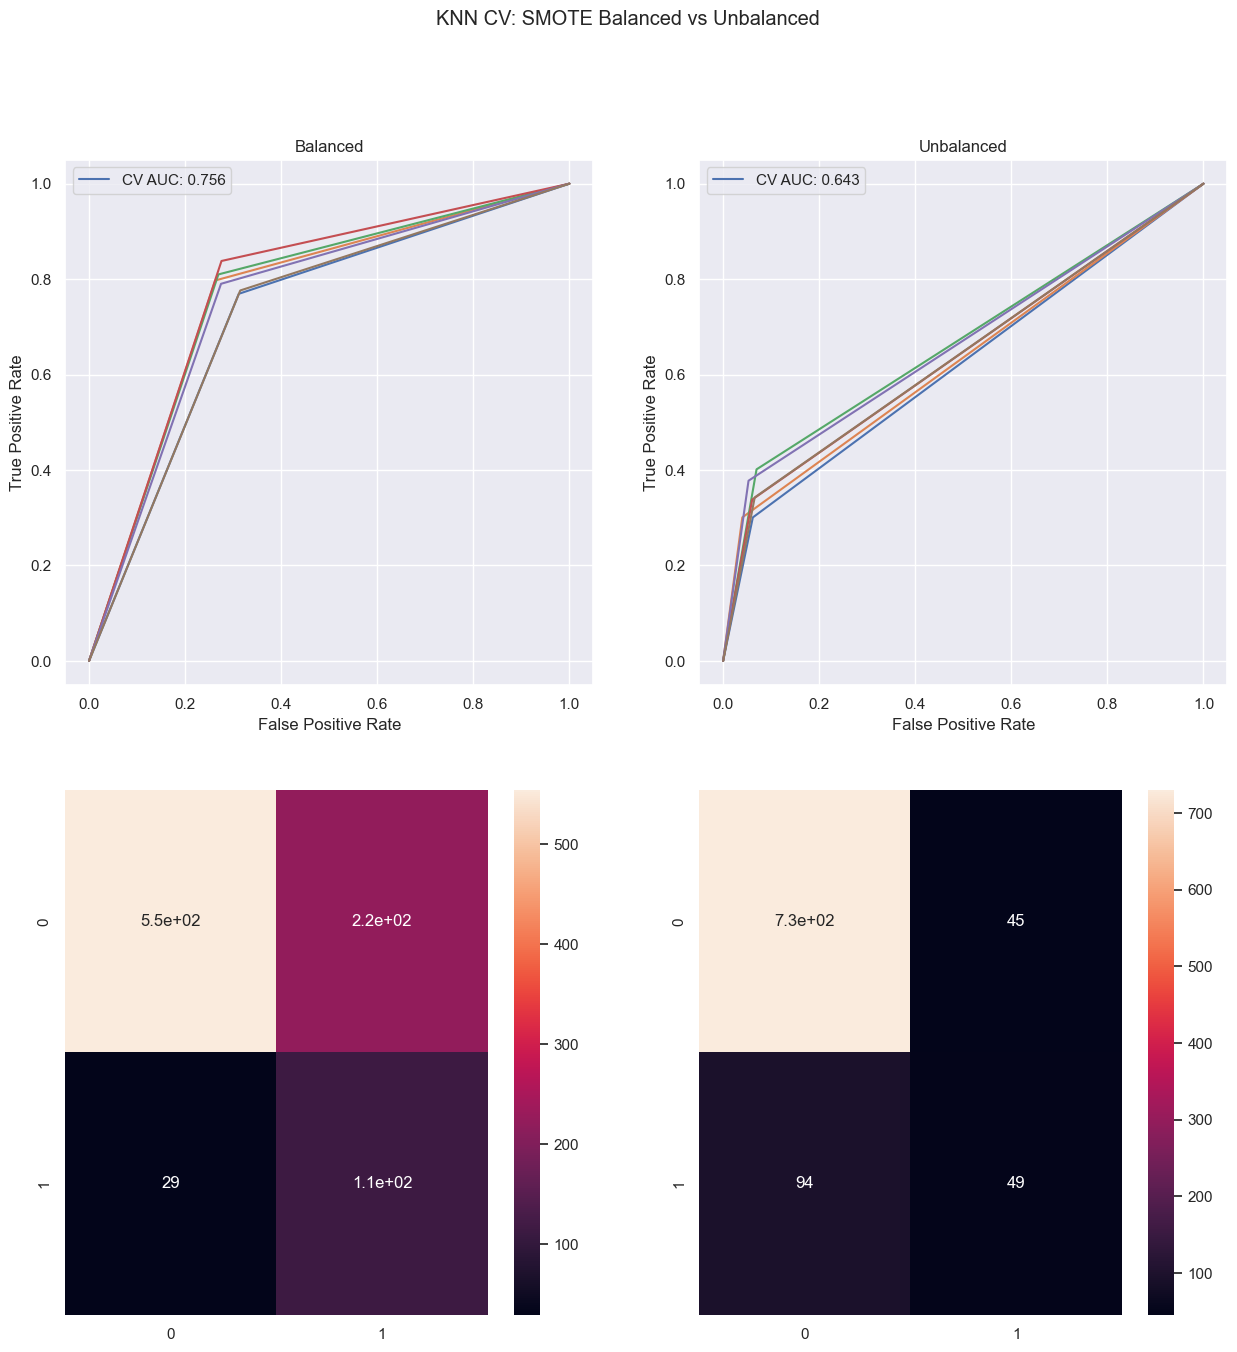

In [117]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'KNN CV: SMOTE Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    

### NearMiss Undersampling

In [118]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()

X_new = X.drop(drop_features.Features, axis=1)
Xnorm_new = stscaler.fit_transform(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

#split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)

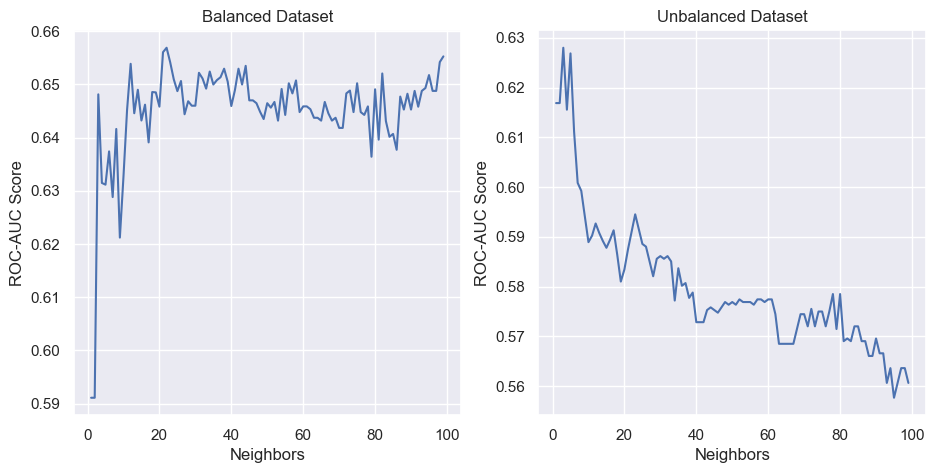

In [119]:
kmax, k_resampled_max = calculate_KNN(Xtrain_resampled,Xtrain,ytrain_resampled,ytrain,Xtest,ytest, neighbors = 100)

In [120]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    knn_unbalanced = KNeighborsClassifier(n_neighbors = kmax, weights='distance')
    knn_unbalanced.fit(train_X, train_y)
    ypred = knn_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = nm.fit_resample(train_X, train_y)
    knn_balanced = KNeighborsClassifier(n_neighbors = k_resampled_max, weights='distance')
    knn_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = knn_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

In [121]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0

ROC_AUC     F1  Precision  Recall
Balanced      0.682  0.438      0.375   0.526
Unbalanced    0.643  0.413      0.522   0.344

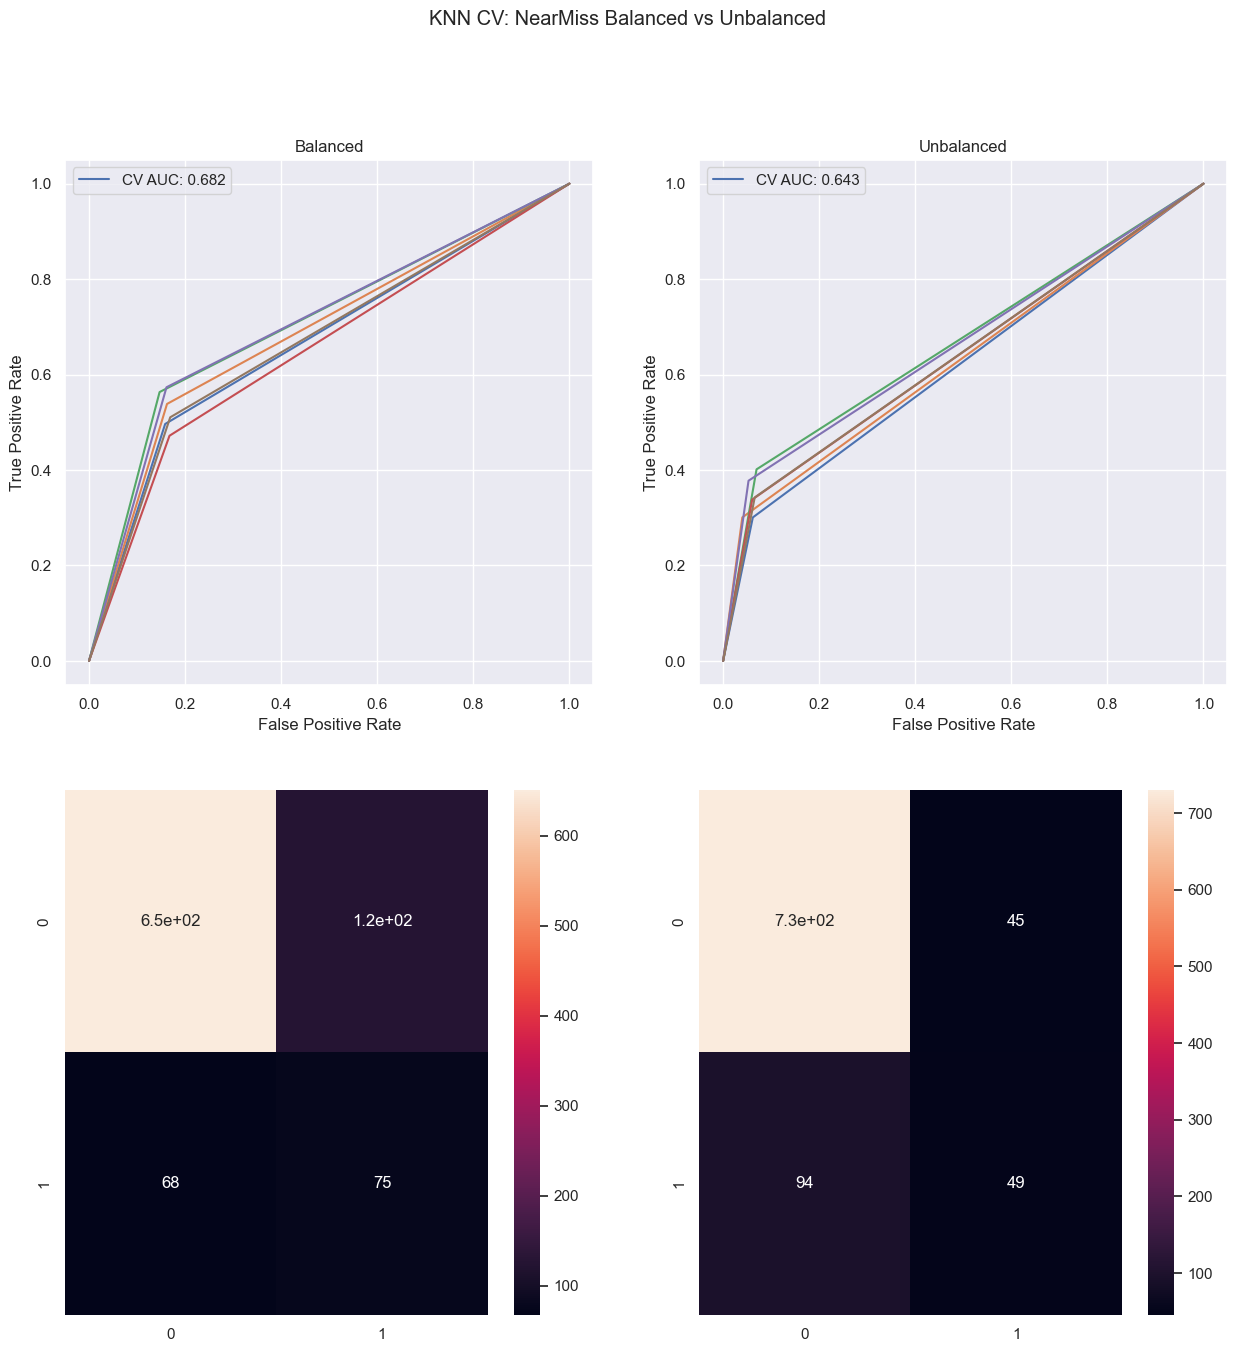

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'KNN CV: NearMiss Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    

# SVM

### SMOTE Oversampling

In [123]:
Xnorm_new.shape

(5510, 12)

In [124]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    svm_unbalanced = SVC(kernel='rbf', class_weight = 'balanced', gamma=0.001, random_state=0)
    svm_unbalanced.fit(train_X, train_y)
    ypred = svm_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = smote.fit_resample(train_X, train_y)
    svm_balanced = SVC(kernel='rbf', C = 0.03, gamma='auto', random_state=0)
    svm_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = svm_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])
    
    
    



In [125]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.774  0.514      0.384   0.778
Unbalanced    0.773  0.515      0.387   0.771

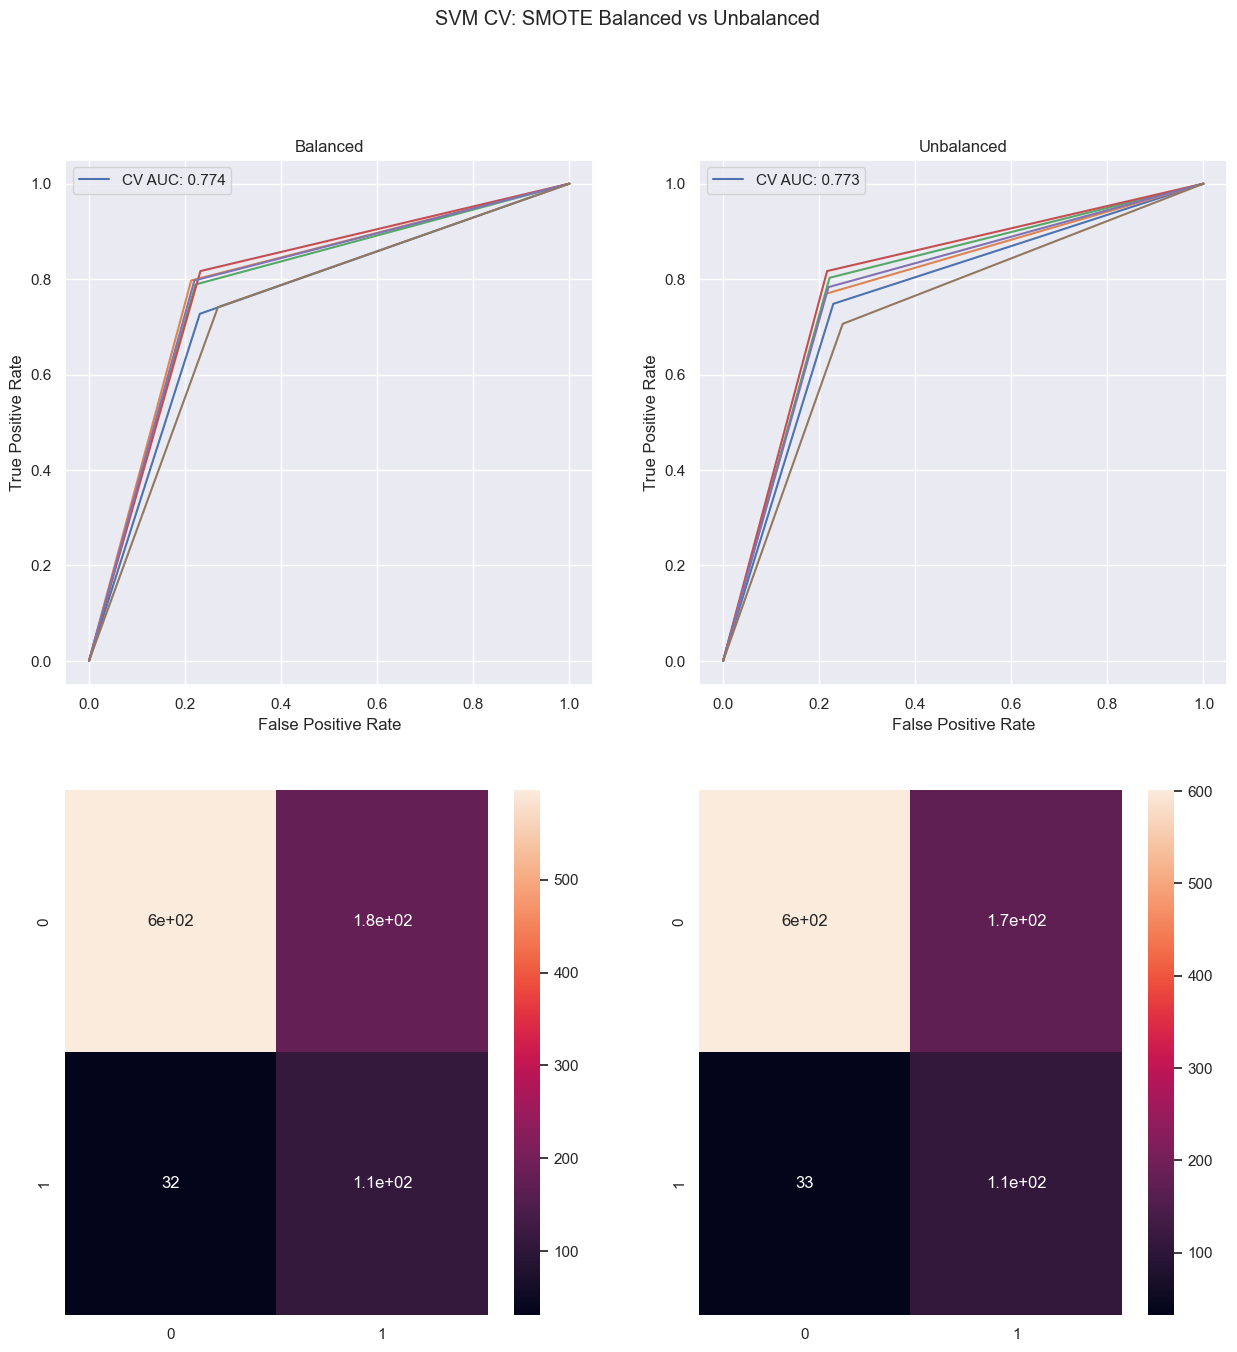

In [126]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'SVM CV: SMOTE Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()
    
    

### NearMiss Undersampling

In [127]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()


In [128]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    svm_unbalanced = SVC(kernel='rbf', class_weight = 'balanced', gamma=0.001)
    svm_unbalanced.fit(train_X, train_y)
    ypred = svm_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = nm.fit_resample(train_X, train_y)
    svm_balanced = SVC(kernel='rbf', class_weight = 'balanced' , gamma=0.001)
    svm_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = svm_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])
    
    
    



In [129]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.734  0.498      0.409   0.638
Unbalanced    0.773  0.515      0.387   0.771

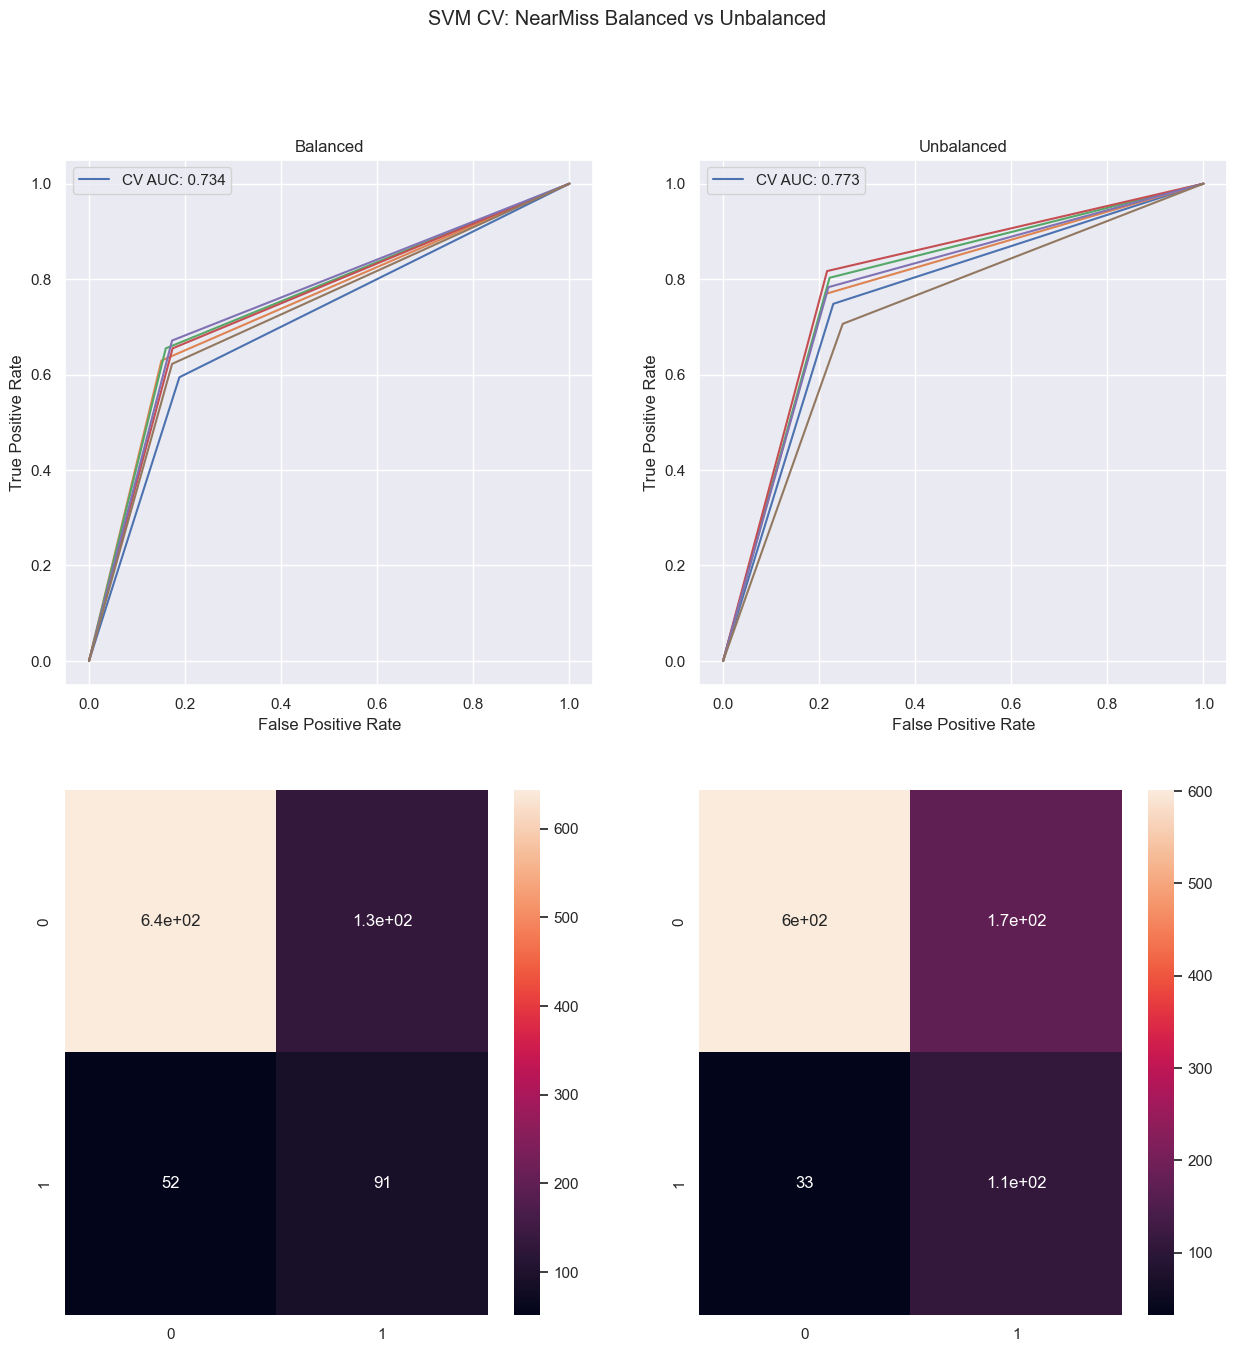

In [130]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'SVM CV: NearMiss Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    

# Classification Trees

### SMOTE Oversampling

In [131]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)

In [132]:
Xtrain_resampled.head()

Location  MaxTemp  Rainfall  Sunshine  WindGustSpeed  WindDir3pm  \
0         5     24.8       0.0       1.6           50.0        13.0   
1         7     29.4       0.0      10.6           44.0         0.0   
2        11     29.3       0.0      10.0           41.0        14.0   
3         1     33.2       1.0      12.5           33.0         5.0   
4        25     17.5       0.0       4.1           50.0         2.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  
0         38.0         35.0       1009.9       1007.6       6.0       8.0  
1         58.0         46.0       1019.5       1016.1       1.0       2.0  
2         35.0         27.0       1018.1       1014.5       3.0       3.0  
3         38.0         20.0       1010.7       1006.6       6.0       1.0  
4         47.0         50.0       1025.8       1023.1       7.0       7.0

In [133]:
classi_tree = DecisionTreeClassifier(random_state=2, criterion='gini', class_weight='balanced')
classi_tree = classi_tree.fit(Xtrain_resampled, ytrain_resampled)
classi_tree.fit(Xtrain_resampled, ytrain_resampled)

ypred_resampled = classi_tree.predict(Xtest)
scores = classification_report(ytest, ypred_resampled)
roc_auc = roc_auc_score(ytest, ypred_resampled)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       934
           1       0.34      0.43      0.38       168

    accuracy                           0.79      1102
   macro avg       0.62      0.64      0.63      1102
weighted avg       0.81      0.79      0.80      1102

roc_auc score: 0.6423154379524829


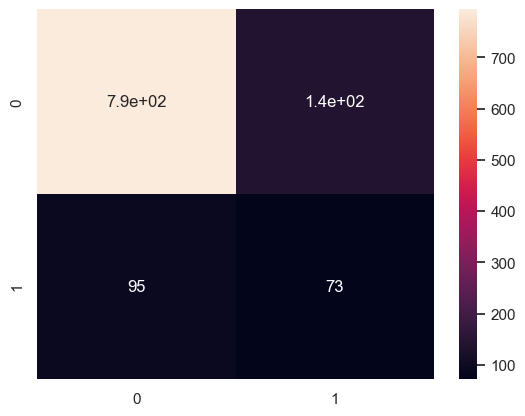

In [134]:
cf = confusion_matrix(ytest,  ypred_resampled)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

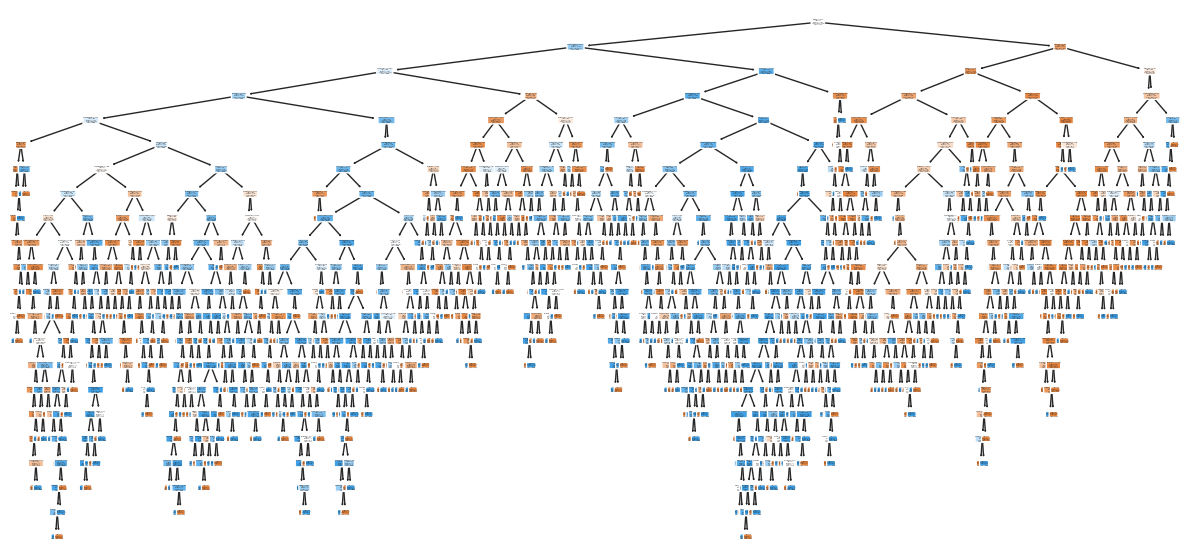

In [135]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

###  Tuning CV

In [136]:
path = classi_tree.cost_complexity_pruning_path(Xtrain_resampled, ytrain_resampled)
alphas = path.ccp_alphas
ccp_alphas = alphas[:-1] #exclude the maximum value of alpha bc it leads to the the root of the tree

alpha_values = []
for a in alphas:
    classi_tree = DecisionTreeClassifier(random_state=0, ccp_alpha = a, criterion='gini', class_weight='balanced')
    scores_crossval = cross_val_score(classi_tree, Xtrain_resampled, ytrain_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    alpha_values.append([a, np.mean(scores_crossval), np.std(scores_crossval)])
    

    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'roc_auc', 'std'])
best_alpha = alpha_results.sort_values(by='roc_auc', ascending=False).iloc[0,0]
print(f'Best alpha: {best_alpha}')

Best alpha: 0.0008421838405422814


In [137]:
classi_tree_pruned = DecisionTreeClassifier(random_state = 2, ccp_alpha=best_alpha, criterion='gini', class_weight='balanced')
classi_tree_pruned.fit(Xtrain_resampled, ytrain_resampled)

#===========balanced
ypred = classi_tree_pruned.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       934
           1       0.35      0.51      0.41       168

    accuracy                           0.78      1102
   macro avg       0.63      0.67      0.64      1102
weighted avg       0.82      0.78      0.80      1102

roc_auc score: 0.6689290812684817


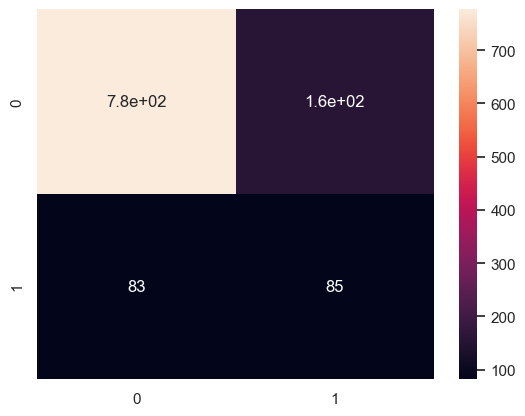

In [138]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

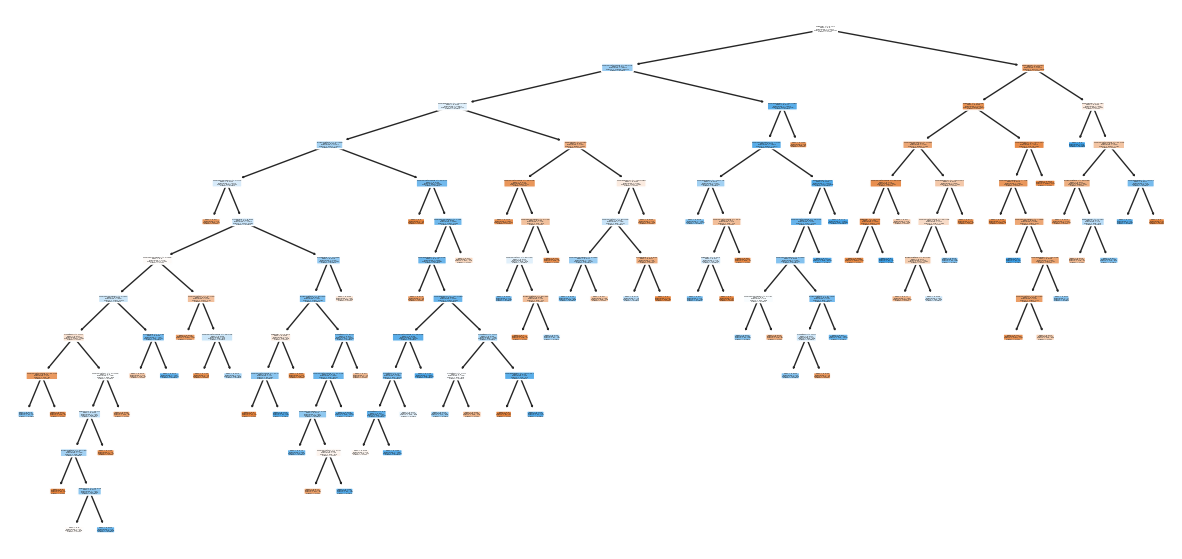

In [139]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree_pruned,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### NearMiss Undersampling

In [140]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)
Xtrain.head()

Location  MaxTemp  Rainfall  Sunshine  WindGustSpeed  WindDir3pm  \
116470         5     24.8       0.0       1.6           50.0        13.0   
94506          7     29.4       0.0      10.6           44.0         0.0   
122139        11     29.3       0.0      10.0           41.0        14.0   
138511         1     33.2       1.0      12.5           33.0         5.0   
21289         25     17.5       0.0       4.1           50.0         2.0   

        Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  
116470         38.0         35.0       1009.9       1007.6       6.0       8.0  
94506          58.0         46.0       1019.5       1016.1       1.0       2.0  
122139         35.0         27.0       1018.1       1014.5       3.0       3.0  
138511         38.0         20.0       1010.7       1006.6       6.0       1.0  
21289          47.0         50.0       1025.8       1023.1       7.0       7.0

In [141]:
classi_tree = DecisionTreeClassifier(random_state=2, criterion='gini', class_weight='balanced')
classi_tree = classi_tree.fit(Xtrain_resampled, ytrain_resampled)
classi_tree.fit(Xtrain_resampled, ytrain_resampled)

ypred_resampled = classi_tree.predict(Xtest)
scores = classification_report(ytest, ypred_resampled)
roc_auc = roc_auc_score(ytest, ypred_resampled)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.88      0.56      0.68       934
           1       0.19      0.57      0.28       168

    accuracy                           0.56      1102
   macro avg       0.53      0.56      0.48      1102
weighted avg       0.77      0.56      0.62      1102

roc_auc score: 0.5646222086264913


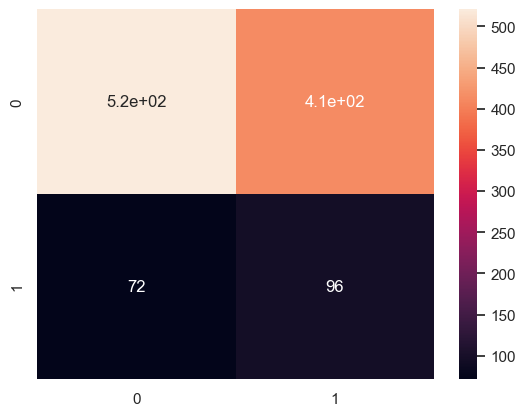

In [142]:
cf = confusion_matrix(ytest,  ypred_resampled)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

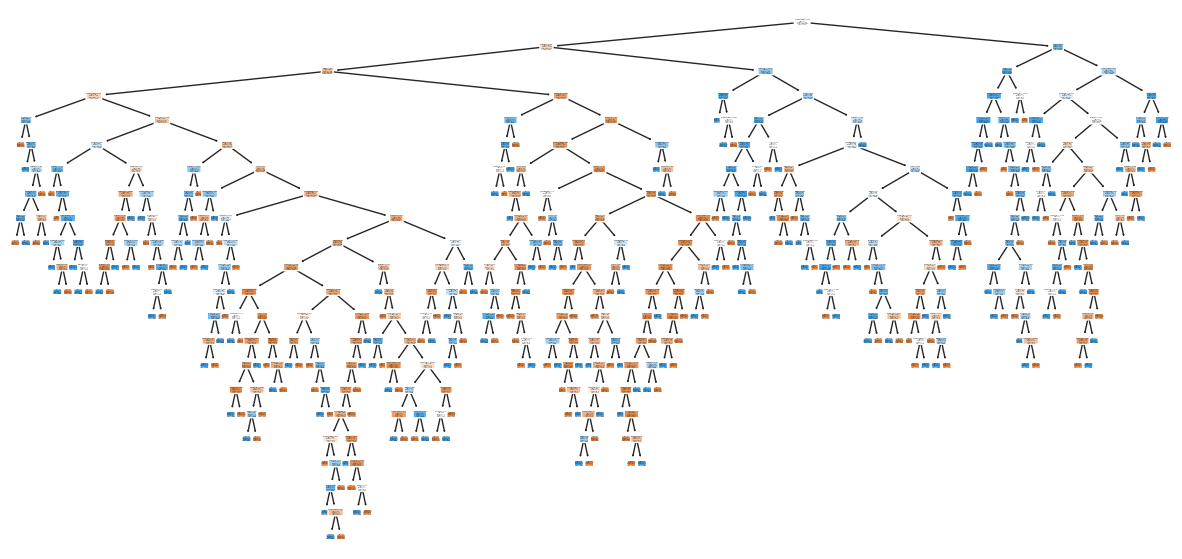

In [143]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### Tuning CV

In [144]:
path = classi_tree.cost_complexity_pruning_path(Xtrain_resampled, ytrain_resampled)
alphas = path.ccp_alphas
ccp_alphas = alphas[:-1] #exclude the maximum value of alpha bc it leads to the the root of the tree

alpha_values = []
for a in alphas:
    classi_tree = DecisionTreeClassifier(random_state=0, ccp_alpha = a, criterion='gini', class_weight='balanced')
    scores_crossval = cross_val_score(classi_tree, Xtrain_resampled, ytrain_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    alpha_values.append([a, np.mean(scores_crossval), np.std(scores_crossval)])
    

    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'roc_auc', 'std'])
best_alpha = alpha_results.sort_values(by='roc_auc', ascending=False).iloc[0,0]
print(f'Best alpha: {best_alpha}')

Best alpha: 0.0030535470001954276


In [145]:
classi_tree_pruned = DecisionTreeClassifier(random_state = 2, ccp_alpha=best_alpha, criterion='gini', class_weight='balanced')
classi_tree_pruned.fit(Xtrain_resampled, ytrain_resampled)

#===========balanced
ypred = classi_tree_pruned.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       934
           1       0.23      0.57      0.33       168

    accuracy                           0.65      1102
   macro avg       0.56      0.61      0.54      1102
weighted avg       0.79      0.65      0.69      1102

roc_auc score: 0.6125025491995513


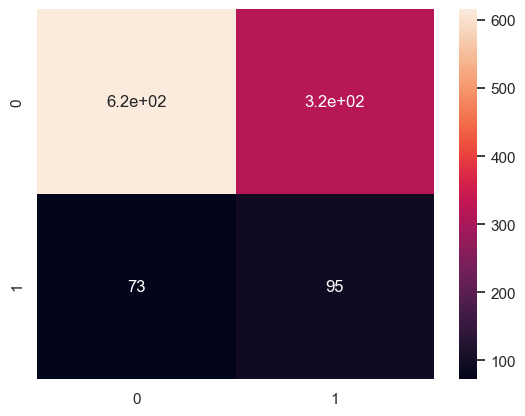

In [146]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

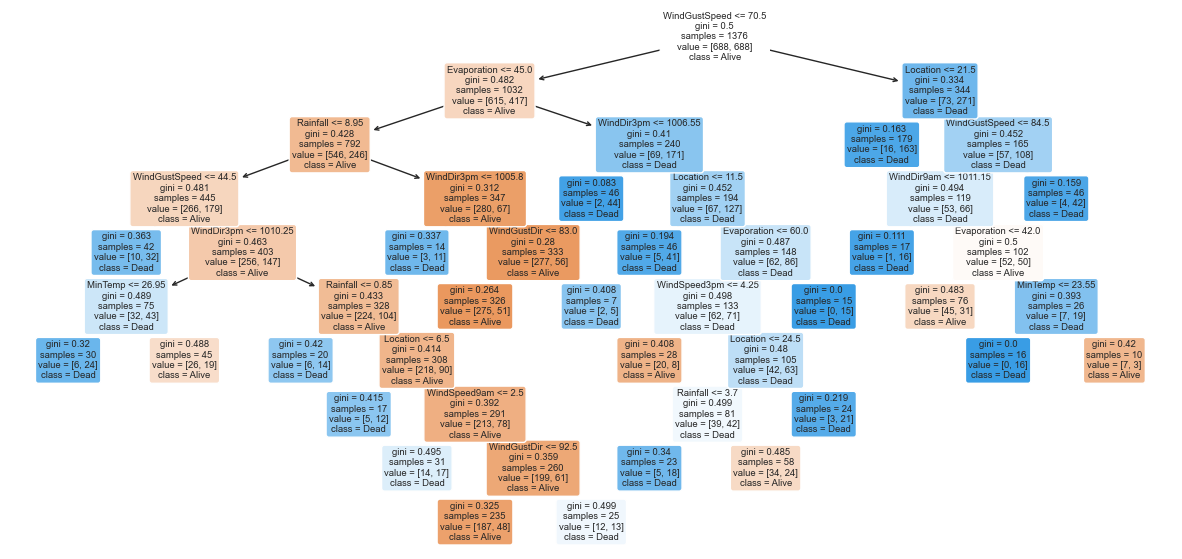

In [147]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree_pruned,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### Unbalanced

In [148]:
Xtrain.shape

(4408, 12)

In [149]:
#===========unbalanced
classi_tree_unbalanced = DecisionTreeClassifier(random_state=2, criterion='entropy',class_weight='balanced' )
classi_tree_unbalanced = classi_tree_unbalanced.fit(Xtrain, ytrain)
classi_tree_unbalanced.fit(Xtrain, ytrain)

ypred = classi_tree_unbalanced.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       934
           1       0.39      0.35      0.37       168

    accuracy                           0.82      1102
   macro avg       0.64      0.62      0.63      1102
weighted avg       0.81      0.82      0.81      1102

roc_auc score: 0.6239038441929234


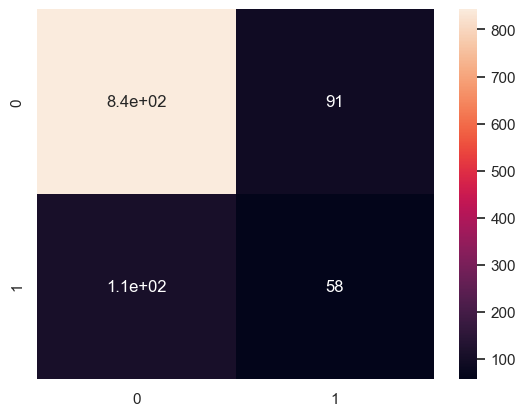

In [150]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

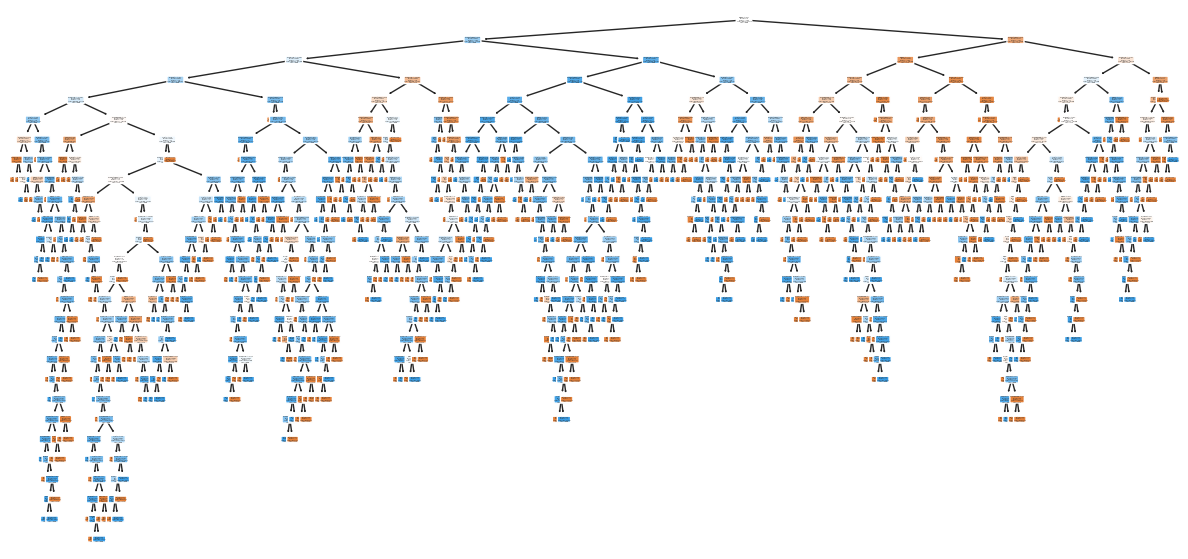

In [151]:

plt.figure(figsize=(15, 7))
plot_tree(classi_tree_unbalanced,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### Unalanced Tuning CV

In [152]:
path = classi_tree_unbalanced.cost_complexity_pruning_path(Xtrain, ytrain)
alphas = path.ccp_alphas
ccp_alphas = alphas[:-1] #exclude the maximum value of alpha bc it leads to the the root of the tree

alpha_values = []
for a in alphas:
    classi_tree = DecisionTreeClassifier(random_state=0, ccp_alpha = a, criterion='entropy', class_weight='balanced')
    scores_crossval = cross_val_score(classi_tree, Xtrain, ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
    alpha_values.append([a, np.mean(scores_crossval), np.std(scores_crossval)])
    

    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'roc_auc', 'std'])
best_alpha = alpha_results.sort_values(by='roc_auc', ascending=False).iloc[0,0]
print(f'Best alpha: {best_alpha}')

Best alpha: 0.005707167834391347


In [153]:
classi_tree_unbalanced_pruned = DecisionTreeClassifier(random_state = 2, ccp_alpha=best_alpha, criterion='entropy', class_weight='balanced')
classi_tree_unbalanced_pruned.fit(Xtrain, ytrain)

#===========balanced
ypred = classi_tree_unbalanced_pruned.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Unbalanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Unbalanced===
              precision    recall  f1-score   support

           0       0.94      0.70      0.80       934
           1       0.32      0.76      0.45       168

    accuracy                           0.71      1102
   macro avg       0.63      0.73      0.63      1102
weighted avg       0.85      0.71      0.75      1102

roc_auc score: 0.7321301111451004


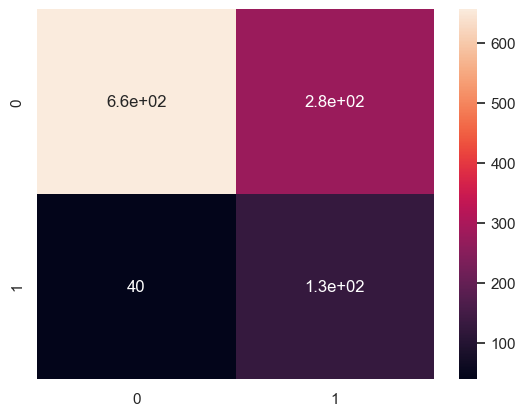

In [154]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

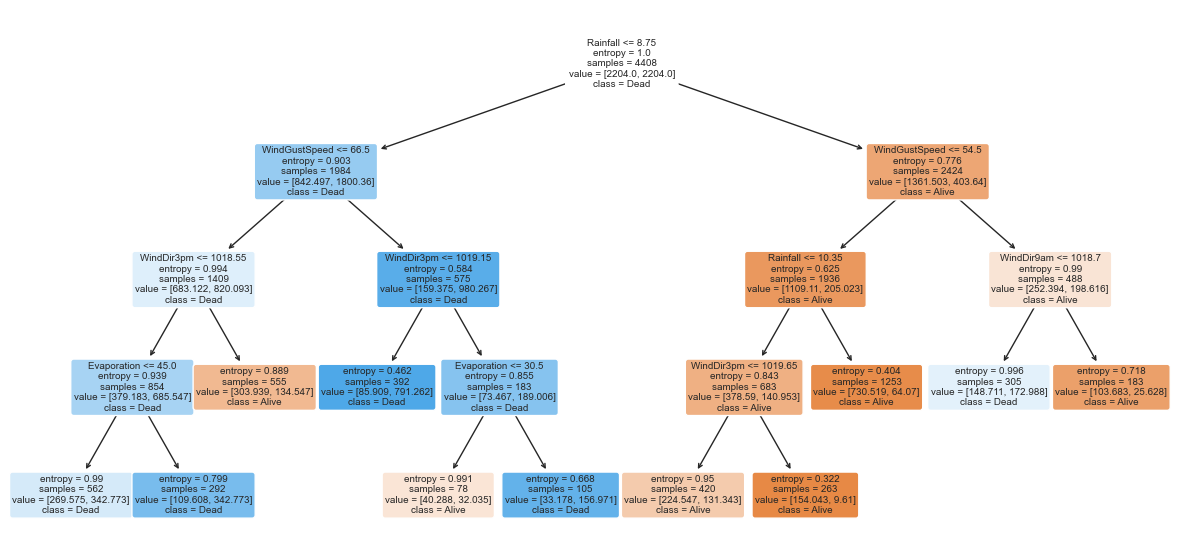

In [155]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree_unbalanced_pruned,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

# ANN

### SMOTE Oversampling

In [156]:
from tensorflow import keras
from tensorflow.keras import layers,Sequential
import tensorflow as tf

Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=2)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)
Xtrain_resampled.head()

Location   MaxTemp  Rainfall  Sunshine  WindGustSpeed  WindDir3pm  \
0 -0.666594  2.208830 -0.398805  1.315579       1.612865    0.453137   
1 -0.786727  0.384615 -0.398805  0.442123      -0.271218    1.330010   
2 -0.426329  1.007888 -0.398805  1.202875      -0.469542   -0.423736   
3  0.774997  1.494346 -0.398805 -0.656741      -0.271218    0.891573   
4 -0.065931 -0.998748  0.105305 -1.192086      -0.667866   -0.204517   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  
0    -2.203789    -1.174599    -1.663404    -1.733467 -0.741362 -0.828976  
1     0.279453    -1.228597    -0.104889    -0.490195  0.016822 -0.018101  
2    -1.198667    -0.958607    -0.640137    -0.804948 -1.499546 -1.234413  
3     0.811577     0.391344    -1.332810    -1.623304  1.154098 -0.423538  
4     0.811577     0.931324     0.965605     1.067829 -0.741362  1.198211

In [157]:
model=tf.keras.Sequential([
    layers.Flatten(input_shape=(X_new.shape[1], )),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 12)                0         
                                                                 
 dense_21 (Dense)            (None, 64)                832       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 128)               8320      
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)              

In [158]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy', 
              metrics=["AUC"])

callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = model.fit(Xtrain_resampled, ytrain_resampled, 
        epochs=150,
        validation_data=(Xtest, ytest),
        batch_size=32, 
        callbacks=[callback],)

Epoch 1/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6903 - auc: 0.5445 - val_loss: 0.6841 - val_auc: 0.7759
Epoch 2/150
233/233 [==============================] - 1s 2ms/step - loss: 0.6825 - auc: 0.6191 - val_loss: 0.6866 - val_auc: 0.8041
Epoch 3/150
233/233 [==============================] - 1s 2ms/step - loss: 0.6746 - auc: 0.6693 - val_loss: 0.6814 - val_auc: 0.8147
Epoch 4/150
233/233 [==============================] - 1s 2ms/step - loss: 0.6620 - auc: 0.7124 - val_loss: 0.6708 - val_auc: 0.8230
Epoch 5/150
233/233 [==============================] - 1s 2ms/step - loss: 0.6438 - auc: 0.7490 - val_loss: 0.6510 - val_auc: 0.8301
Epoch 6/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6175 - auc: 0.7696 - val_loss: 0.6187 - val_auc: 0.8338
Epoch 7/150
233/233 [==============================] - 1s 2ms/step - loss: 0.5898 - auc: 0.7864 - val_loss: 0.5825 - val_auc: 0.8367
Epoch 8/150
233/233 [==============================] - 1s 3ms/step - 

<AxesSubplot:title={'center':'Loss'}>

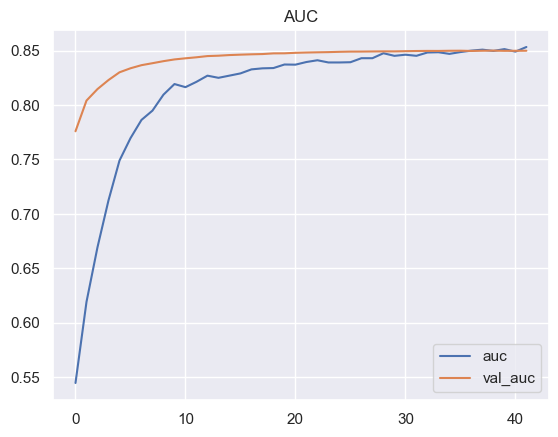

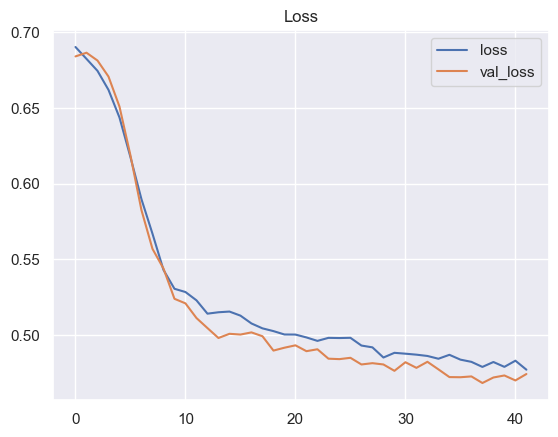

In [159]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       929
           1       0.36      0.80      0.50       173

    accuracy                           0.75      1102
   macro avg       0.66      0.77      0.67      1102
weighted avg       0.86      0.75      0.78      1102



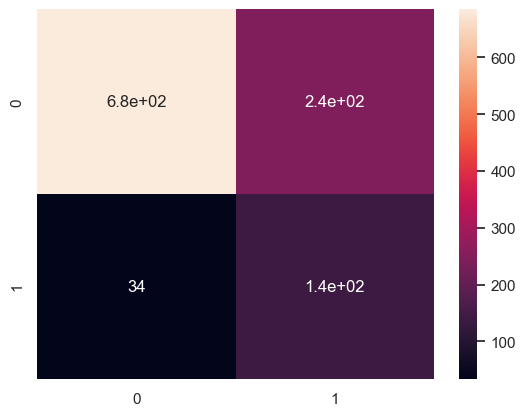

In [160]:
ypred = model.predict(Xtest)
cf = confusion_matrix(ytest, ypred.round())
sns.heatmap(pd.DataFrame(cf) , annot=True)
print(classification_report(ytest,ypred.round()))

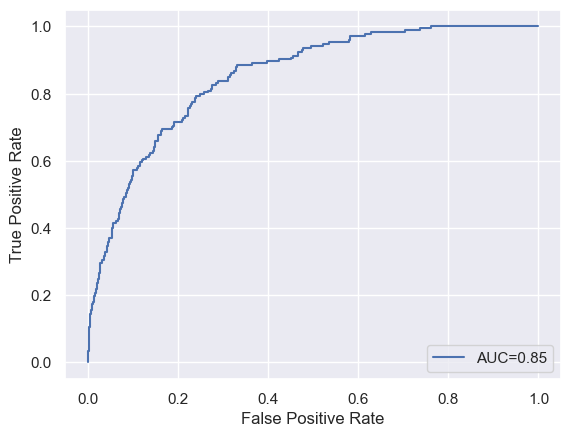

In [161]:
#create ROC curve
fpr, tpr, _ = roc_curve(ytest,  ypred)
auc = roc_auc_score(ytest, ypred)


plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### NearMiss Undersampling

In [162]:
from tensorflow import keras
from tensorflow.keras import layers,Sequential
import tensorflow as tf

Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=2)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)

In [163]:
model=tf.keras.Sequential([
    layers.Flatten(input_shape=(X_new.shape[1], )),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 12)                0         
                                                                 
 dense_28 (Dense)            (None, 64)                832       
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 128)               8320      
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)              

In [164]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy', 
              metrics=["AUC"])

callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = model.fit(Xtrain_resampled, ytrain_resampled, 
        epochs=150,
        validation_data=(Xtest, ytest),
        batch_size=32, 
        callbacks=[callback],)

Epoch 1/150
43/43 [==============================] - 1s 8ms/step - loss: 0.7039 - auc: 0.4141 - val_loss: 0.6766 - val_auc: 0.6180
Epoch 2/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6974 - auc: 0.4717 - val_loss: 0.6839 - val_auc: 0.6736
Epoch 3/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6937 - auc: 0.5078 - val_loss: 0.6901 - val_auc: 0.7306
Epoch 4/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6898 - auc: 0.5551 - val_loss: 0.6956 - val_auc: 0.7521
Epoch 5/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6875 - auc: 0.5763 - val_loss: 0.7010 - val_auc: 0.7652
Epoch 6/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6865 - auc: 0.5981 - val_loss: 0.7054 - val_auc: 0.7658
Epoch 7/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6796 - auc: 0.6566 - val_loss: 0.7101 - val_auc: 0.7735
Epoch 8/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6810 - a

<AxesSubplot:title={'center':'Loss'}>

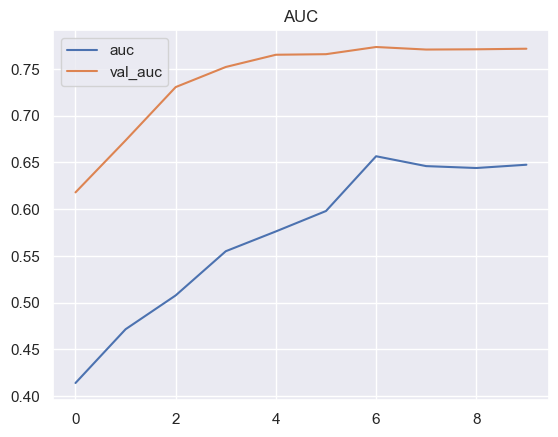

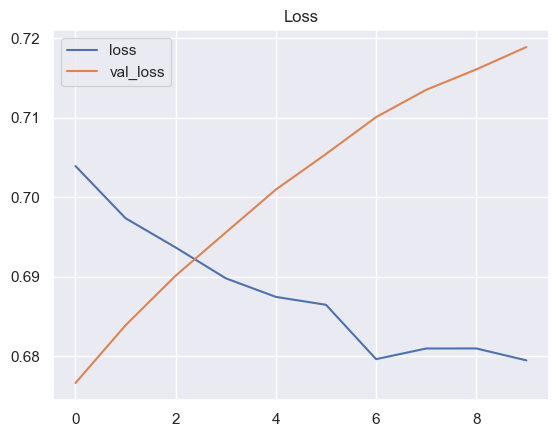

In [165]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       929
           1       0.16      1.00      0.27       173

    accuracy                           0.17      1102
   macro avg       0.58      0.51      0.15      1102
weighted avg       0.87      0.17      0.06      1102



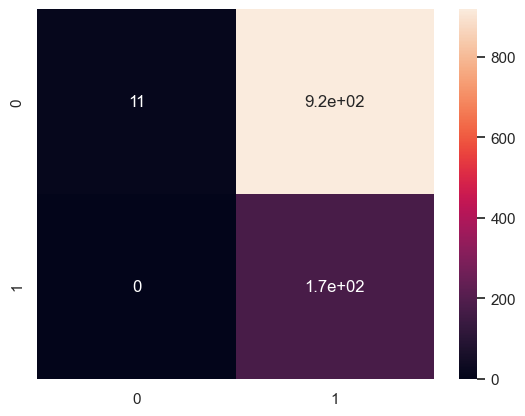

In [166]:
ypred = model.predict(Xtest)
cf = confusion_matrix(ytest, ypred.round())
sns.heatmap(pd.DataFrame(cf) , annot=True)
print(classification_report(ytest,ypred.round()))

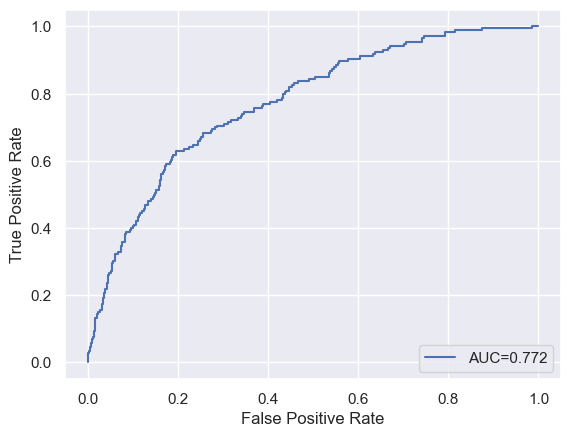

In [167]:
#create ROC curve
fpr, tpr, _ = roc_curve(ytest,  ypred)
auc = roc_auc_score(ytest, ypred)


plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Unbalanced

In [168]:
Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=2)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)

In [169]:
model=tf.keras.Sequential([
    layers.Flatten(input_shape=(X_new.shape[1], )),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 12)                0         
                                                                 
 dense_35 (Dense)            (None, 64)                832       
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 128)               8320      
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dropout_16 (Dropout)        (None, 128)              

In [170]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy', 
              metrics=["AUC"])

callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = model.fit(Xtrain, ytrain, 
        epochs=150,
        validation_data=(Xtest, ytest),
        batch_size=32, 
        callbacks=[callback],)

Epoch 1/150
138/138 [==============================] - 1s 4ms/step - loss: 0.6625 - auc: 0.4920 - val_loss: 0.6246 - val_auc: 0.4733
Epoch 2/150
138/138 [==============================] - 0s 3ms/step - loss: 0.5693 - auc: 0.4669 - val_loss: 0.5603 - val_auc: 0.4587
Epoch 3/150
138/138 [==============================] - 0s 3ms/step - loss: 0.5090 - auc: 0.4458 - val_loss: 0.5103 - val_auc: 0.4895
Epoch 4/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4691 - auc: 0.5048 - val_loss: 0.4757 - val_auc: 0.5336
Epoch 5/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4569 - auc: 0.4966 - val_loss: 0.4553 - val_auc: 0.5885
Epoch 6/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4463 - auc: 0.5363 - val_loss: 0.4412 - val_auc: 0.6346
Epoch 7/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4351 - auc: 0.5707 - val_loss: 0.4301 - val_auc: 0.6718
Epoch 8/150
138/138 [==============================] - 0s 3ms/step - 

138/138 [==============================] - 0s 3ms/step - loss: 0.3400 - auc: 0.8209 - val_loss: 0.3311 - val_auc: 0.8431
Epoch 63/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3397 - auc: 0.8197 - val_loss: 0.3308 - val_auc: 0.8438
Epoch 64/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3436 - auc: 0.8169 - val_loss: 0.3305 - val_auc: 0.8435
Epoch 65/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3442 - auc: 0.8152 - val_loss: 0.3302 - val_auc: 0.8435
Epoch 66/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3414 - auc: 0.8186 - val_loss: 0.3300 - val_auc: 0.8435


<AxesSubplot:title={'center':'Loss'}>

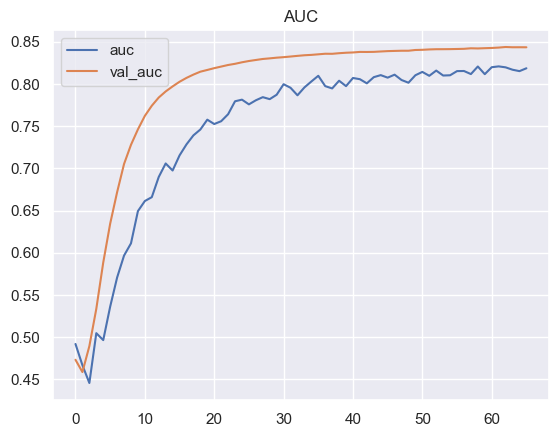

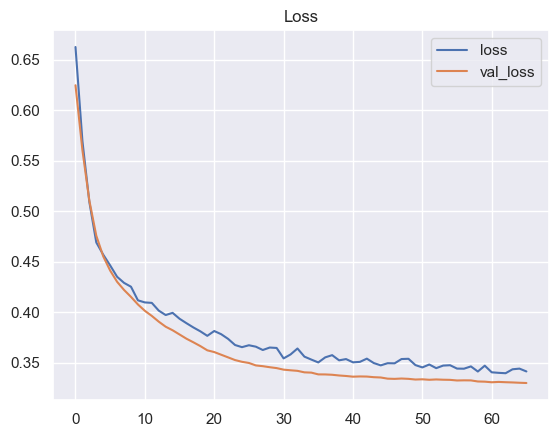

In [171]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       929
           1       0.52      0.35      0.42       173

    accuracy                           0.85      1102
   macro avg       0.70      0.65      0.67      1102
weighted avg       0.83      0.85      0.84      1102



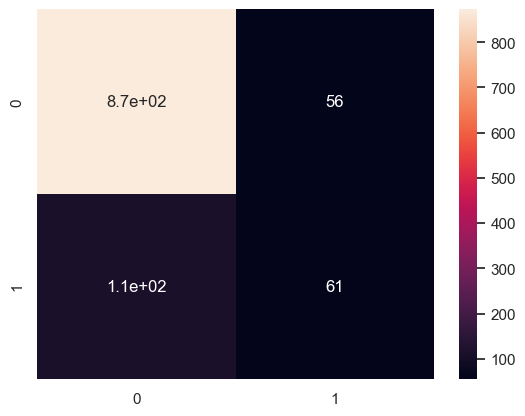

In [172]:
ypred = model.predict(Xtest)
cf = confusion_matrix(ytest, ypred.round())
sns.heatmap(pd.DataFrame(cf) , annot=True)
print(classification_report(ytest,ypred.round()))

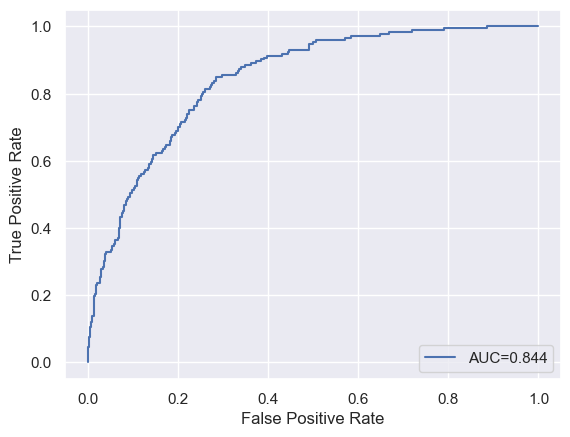

In [173]:
#create ROC curve
fpr, tpr, _ = roc_curve(ytest,  ypred)
auc = roc_auc_score(ytest, ypred)


plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

 # Rule Induction: RIPPER

### SMOTE Oversampling

In [174]:
import wittgenstein as witt
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NearMiss


In [175]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)

In [189]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(X_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    ripper = witt.RIPPER(prune_size=0.001, k=3, random_state=0, verbosity=1)
    ripper.fit(train_X, train_y)
    ypred = ripper.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    

    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = smote.fit_resample(train_X, train_y)
    ripper = witt.RIPPER(prune_size=0.001, k=3,random_state=0)
    ripper.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = ripper.predict(test_X)

    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

    
    



discretizing 10 features

GREW INITIAL RULESET:
[[7=>71.0] V
[11=7.0 ^ 4=>52.0] V
[7=63.0-71.0] V
[7=58.0-63.0] V
[3=<2.5] V
[3=5.0-6.8] V
[3=2.5-5.0] V
[4=>52.0 ^ 2=>0.6] V
[3=6.8-8.2] V
[7=53.0-58.0]]

optimization run 1 of 3

OPTIMIZED RULESET:
[[7=>71.0] V
[11=7.0 ^ 4=>52.0] V
[7=63.0-71.0] V
[7=58.0-63.0] V
[3=<2.5] V
[3=5.0-6.8] V
[3=2.5-5.0] V
[4=>52.0 ^ 2=>0.6] V
[3=6.8-8.2] V
[7=53.0-58.0]]

No changes were made. Halting optimization.
GREW FINAL RULES
[[7=>71.0] V
[11=7.0 ^ 4=>52.0] V
[7=63.0-71.0] V
[7=58.0-63.0] V
[3=<2.5] V
[3=5.0-6.8] V
[3=2.5-5.0] V
[4=>52.0 ^ 2=>0.6] V
[3=6.8-8.2] V
[7=53.0-58.0] V
[7=>71.0] V
[11=7.0 ^ 4=>52.0] V
[7=63.0-71.0] V
[7=58.0-63.0] V
[3=<2.5] V
[3=5.0-6.8] V
[3=2.5-5.0] V
[4=>52.0 ^ 2=>0.6] V
[3=6.8-8.2] V
[7=53.0-58.0] V
[3=8.2-9.2 ^ 9=1014.0-1015.8] V
[9=1007.7-1010.3]]

FINAL RULESET:
[[7=>71.0] V
[11=7.0 ^ 4=>52.0] V
[3=<2.5] V
[3=2.5-5.0] V
[4=>52.0 ^ 2=>0.6] V
[3=8.2-9.2 ^ 9=1014.0-1015.8]]

discretizing 10 features

GREW INITIAL RULESE

In [187]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.673  0.443      0.435   0.457
Unbalanced    0.711  0.460      0.372   0.615

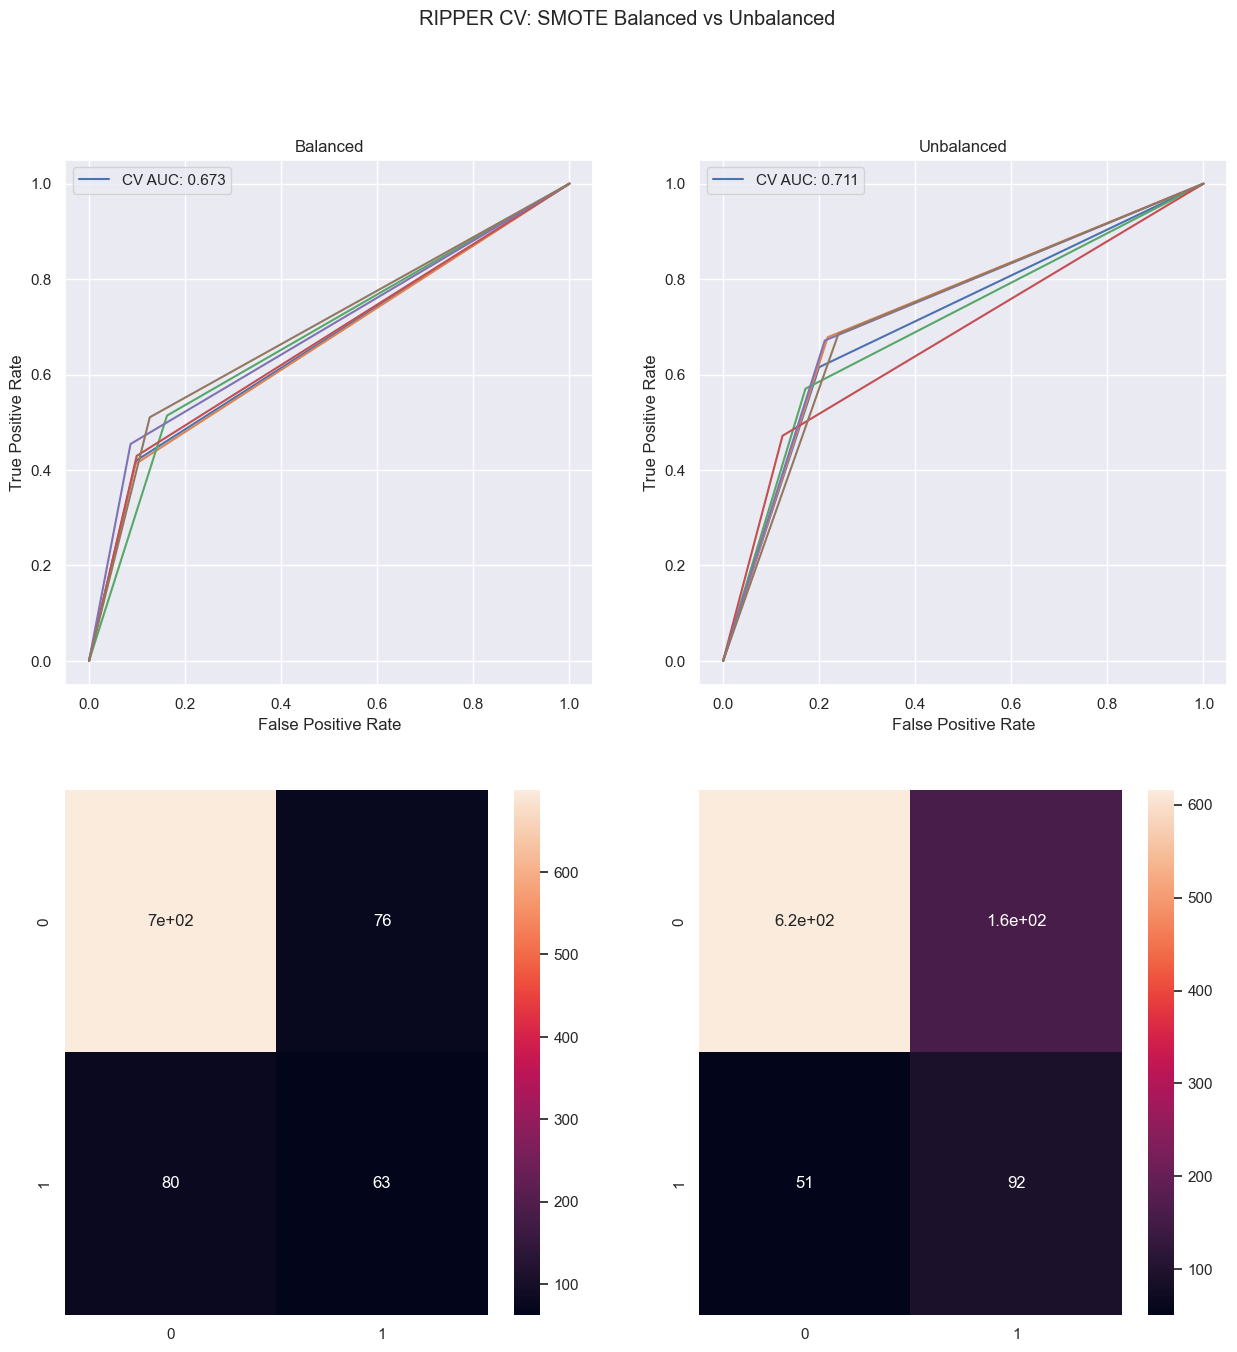

In [188]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'RIPPER CV: SMOTE Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.median(cflist,axis=0)
cf_resampled = np.median(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    
    

### NearMiss Undersampling

In [179]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)

In [180]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(X_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    ripper = witt.RIPPER(prune_size=0.001, k=3, random_state=0)
    ripper.fit(train_X, train_y)
    ypred = ripper.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    

    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = nm.fit_resample(train_X, train_y)
    ripper = witt.RIPPER(prune_size=0.001, k=3,random_state=0)
    ripper.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = ripper.predict(test_X)

    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

    
    



In [181]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.622  0.352      0.248   0.645
Unbalanced    0.711  0.460      0.372   0.615

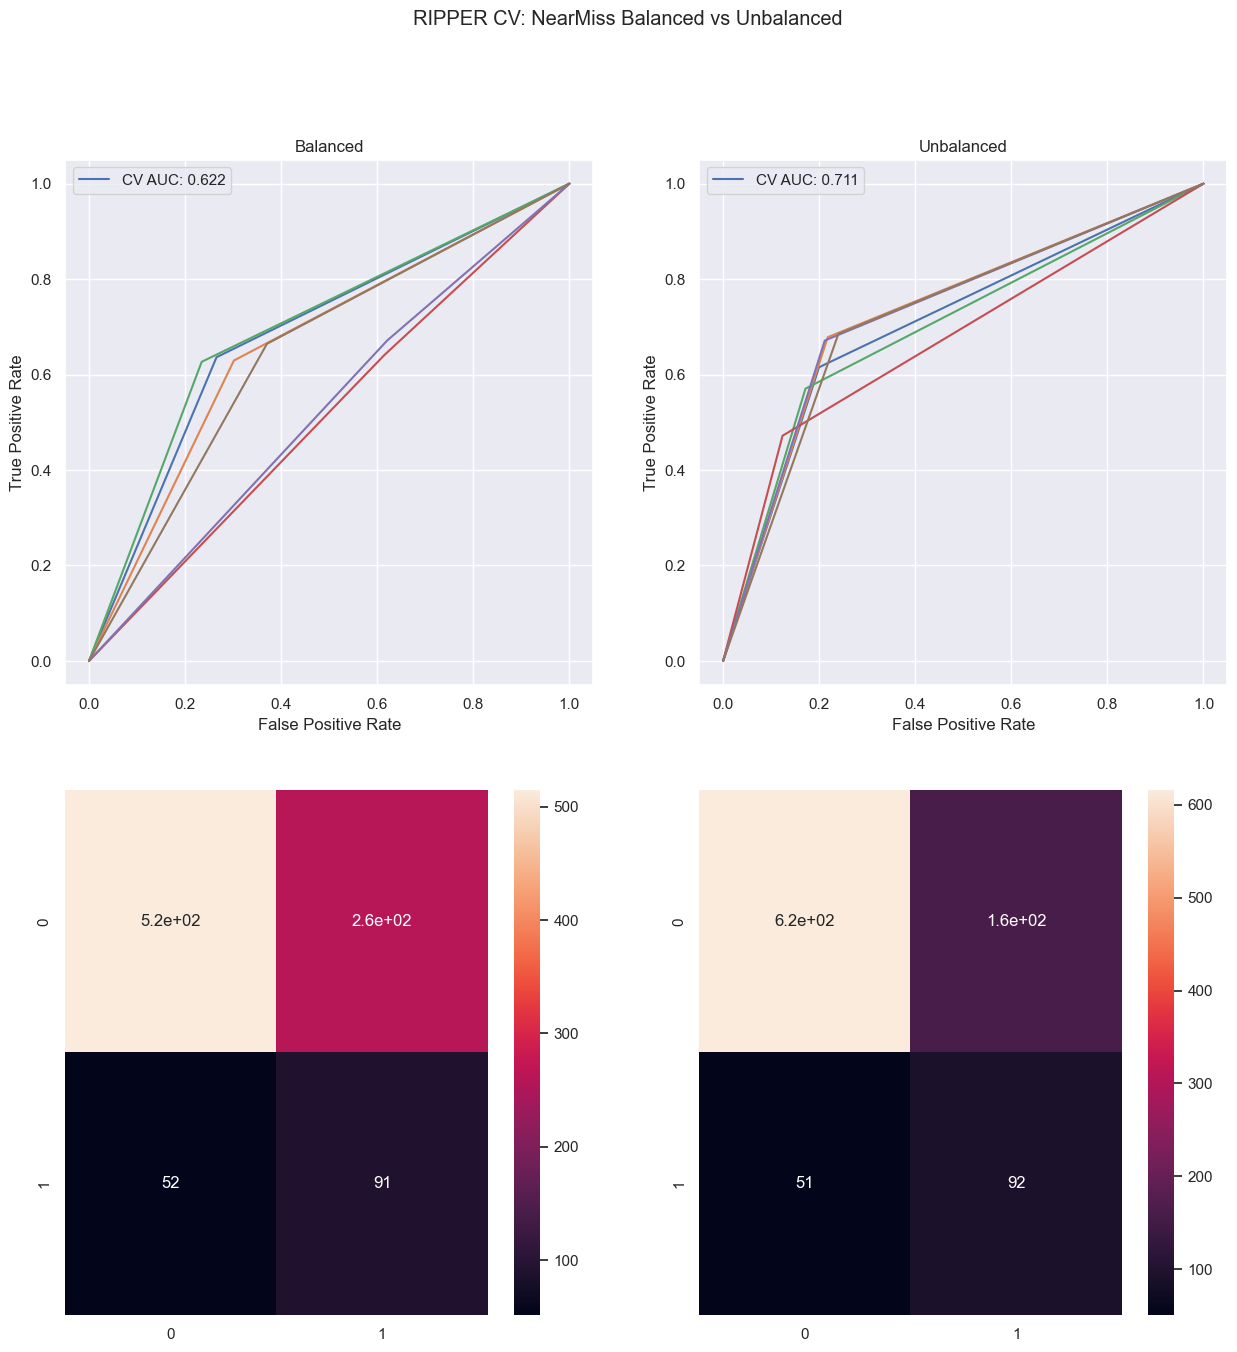

In [182]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'RIPPER CV: NearMiss Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.median(cflist,axis=0)
cf_resampled = np.median(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    
    